# Predicting Buying Session - Modeling

## Init

In [1]:
# https://stackoverflow.com/questions/9031783/hide-all-warnings-in-ipython

from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline
import seaborn as sns

In [3]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from sklearn.preprocessing import RobustScaler, StandardScaler

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import confusion_matrix, classification_report, recall_score

from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn.feature_selection import SelectKBest, chi2, RFE, SelectFromModel

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.model_selection import cross_val_score

import joblib

C:\Users\gabri\anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [4]:
df = pd.read_csv('online_shoppers_intention.csv')

In [5]:
num_feats = ['Administrative', 'Administrative_Duration', 'Informational', 
             'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 
             'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']

In [6]:
obj_feats = ['Month', 'OperatingSystems', 'Browser', 'Region',
             'TrafficType', 'VisitorType']
df[obj_feats] = df[obj_feats].astype('object')

cat_feats = ['Month', 'OperatingSystems', 'Browser', 'Region',
             'TrafficType', 'VisitorType', 'Weekend']

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  object 
 12  Browser                  12330 non-null  object 
 13  Region                   12330 non-null  object 
 14  TrafficType           

In [8]:
df = df[['Revenue', 'Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType',
       'Weekend']]

In [9]:
df.columns

Index(['Revenue', 'Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType',
       'Weekend'],
      dtype='object')

## Preprocessing

In [10]:
onehot = OneHotEncoder()
for feat in ['Month', 'OperatingSystems', 'Browser', 'Region',
             'TrafficType', 'VisitorType']:
    onehotvalue = onehot.fit_transform(df[feat].values.reshape(-1,1)).toarray()
    onehotcols = pd.DataFrame(onehotvalue, columns = [
        feat + '_' + str(onehot.categories_[0][i])
        for i in range(len(onehot.categories_[0]))
    ])
    df = pd.concat([df, onehotcols], axis = 1)
    print(f'{feat} encoded')
    df = df.drop(columns=feat)

Month encoded
OperatingSystems encoded
Browser encoded
Region encoded
TrafficType encoded
VisitorType encoded


In [11]:
label_encoder = LabelEncoder()
for feat in ['Weekend', 'Revenue']:
    df[feat] = label_encoder.fit_transform(df[feat])
    print({index: label for index, label in enumerate(label_encoder.classes_)})
    print(f'{feat} encoded')

{0: False, 1: True}
Weekend encoded
{0: False, 1: True}
Revenue encoded


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 75 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Revenue                        12330 non-null  int32  
 1   Administrative                 12330 non-null  int64  
 2   Administrative_Duration        12330 non-null  float64
 3   Informational                  12330 non-null  int64  
 4   Informational_Duration         12330 non-null  float64
 5   ProductRelated                 12330 non-null  int64  
 6   ProductRelated_Duration        12330 non-null  float64
 7   BounceRates                    12330 non-null  float64
 8   ExitRates                      12330 non-null  float64
 9   PageValues                     12330 non-null  float64
 10  SpecialDay                     12330 non-null  float64
 11  Weekend                        12330 non-null  int32  
 12  Month_Aug                      12330 non-null 

## Unscaled Data

### Split Train/Test 80/20

In [13]:
X = df.iloc[:,1:]
y = df['Revenue']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.20,
                                                    random_state = 88)

for data in [x_train, x_test, y_train, y_test]:
    print(data.shape)

(9864, 74)
(2466, 74)
(9864,)
(2466,)


### Spot Check Classification Algorithms
See at a glance which models are more suitable to the problem. Later the most promising models will be selected.

Purpose of model is to give incentives to sessions predicted not to end with a purchase (0).
Incentives reduce the Company's sales revenue, so it is important to surpress false negatives. This refers to visitors that are falsely predicted to not purchase. We do not want to give discounts to visitors that will purchase anyway.

In cases where there are wide disparities in the cost of false negatives vs. false positives, it may be critical to minimize one type of classification error.

Model evaluation will be based on:
- Recall 1/ precision 0
- Test accuracy score (if first criteria are tied)

#### LogReg

Train score: 88.35%
Test score: 88.08%

              precision    recall  f1-score   support

           0       0.89      0.97      0.93      2073
           1       0.74      0.39      0.51       393

    accuracy                           0.88      2466
   macro avg       0.82      0.68      0.72      2466
weighted avg       0.87      0.88      0.87      2466



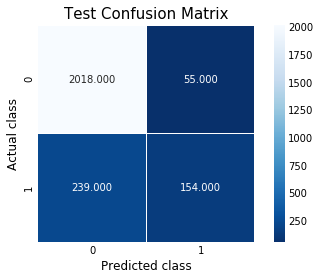

In [14]:
# LOGISTIC REGRESSION
classifier = LogisticRegression(solver='newton-cg',
                                penalty='l2',
                                max_iter=100,
                                random_state=1
                               )
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)

# METRICS
print(f'Train score: {round(classifier.score(x_train, y_train)*100, 2)}%')
print(f'Test score: {round(classifier.score(x_test, y_test)*100, 2)}%\n')

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Test Confusion Matrix', size = 15)
plt.show()

#### DT

Train score: 100.0%
Test score: 87.35%

              precision    recall  f1-score   support

           0       0.92      0.92      0.92      2073
           1       0.60      0.60      0.60       393

    accuracy                           0.87      2466
   macro avg       0.76      0.76      0.76      2466
weighted avg       0.87      0.87      0.87      2466



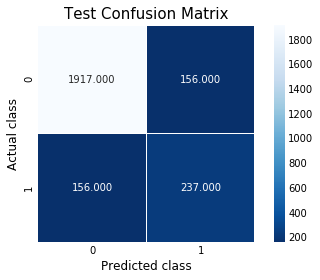

In [15]:
# DECISION TREE
classifier = DecisionTreeClassifier(criterion='gini', 
                                    max_depth=None, 
                                    min_samples_split=2,
                                    min_samples_leaf=1,
                                    random_state=1
                                   )
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)

# METRICS
print(f'Train score: {round(classifier.score(x_train, y_train)*100, 2)}%')
print(f'Test score: {round(classifier.score(x_test, y_test)*100, 2)}%\n')

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Test Confusion Matrix', size = 15)
plt.show()

In [16]:
# VISUALIZE TREE
dot_data = StringIO()
export_graphviz(classifier, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = x_train.columns, class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('DT raw.png')
Image(graph.create_png())

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.780092 to fit

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.780092 to fit



#### RF

Train score: 100.0%
Test score: 90.43%

              precision    recall  f1-score   support

           0       0.92      0.97      0.94      2073
           1       0.78      0.55      0.65       393

    accuracy                           0.90      2466
   macro avg       0.85      0.76      0.80      2466
weighted avg       0.90      0.90      0.90      2466



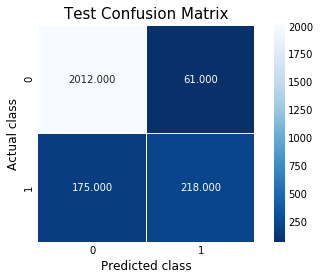

In [17]:
# RANDOM FOREST
classifier = RandomForestClassifier(criterion='gini', 
                                    max_depth=None, 
                                    min_samples_split=2, 
                                    min_samples_leaf=1, 
                                    n_estimators=100,
                                    random_state=1
                                   )
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)

# METRICS
print(f'Train score: {round(classifier.score(x_train, y_train)*100, 2)}%')
print(f'Test score: {round(classifier.score(x_test, y_test)*100, 2)}%\n')

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Test Confusion Matrix', size = 15)
plt.show()

#### KNN

Train score: 89.42%
Test score: 86.62%

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      2073
           1       0.66      0.34      0.44       393

    accuracy                           0.87      2466
   macro avg       0.77      0.65      0.68      2466
weighted avg       0.85      0.87      0.85      2466



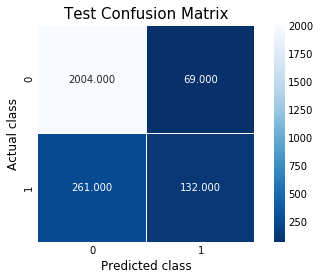

In [18]:
# K NEAREST NEIGHBORS
classifier = KNeighborsClassifier(n_neighbors=5,
                                  algorithm='auto'
                                 )
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)

# METRICS
print(f'Train score: {round(classifier.score(x_train, y_train)*100, 2)}%')
print(f'Test score: {round(classifier.score(x_test, y_test)*100, 2)}%\n')

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Test Confusion Matrix', size = 15)
plt.show()

#### Naive Bayes

Train score: 85.07%
Test score: 85.89%

              precision    recall  f1-score   support

           0       0.93      0.90      0.91      2073
           1       0.55      0.64      0.59       393

    accuracy                           0.86      2466
   macro avg       0.74      0.77      0.75      2466
weighted avg       0.87      0.86      0.86      2466



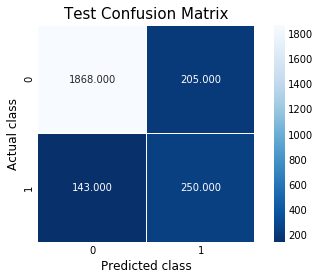

In [19]:
# NAIVE BAYES
classifier = BernoulliNB(alpha=1.0
                       )
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)

# METRICS
print(f'Train score: {round(classifier.score(x_train, y_train)*100, 2)}%')
print(f'Test score: {round(classifier.score(x_test, y_test)*100, 2)}%\n')

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Test Confusion Matrix', size = 15)
plt.show()

#### SVM

In [20]:
# %%capture output

# # SUPPORT VECTOR MACHINES
# classifier = SVC(kernel='linear',
#                  random_state=1
#                 )
# classifier.fit(x_train, y_train)
# y_pred = classifier.predict(x_test)

# # METRICS
# print(f'Train score: {round(classifier.score(x_train, y_train)*100, 2)}%')
# print(f'Test score: {round(classifier.score(x_test, y_test)*100, 2)}%\n')

# print(classification_report(y_test, y_pred))

# cm = confusion_matrix(y_test, y_pred)

# sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
# plt.xlabel('Predicted class')
# plt.ylabel('Actual class')
# plt.title('Test Confusion Matrix', size = 15)
# plt.show()

In [21]:
# output.show()

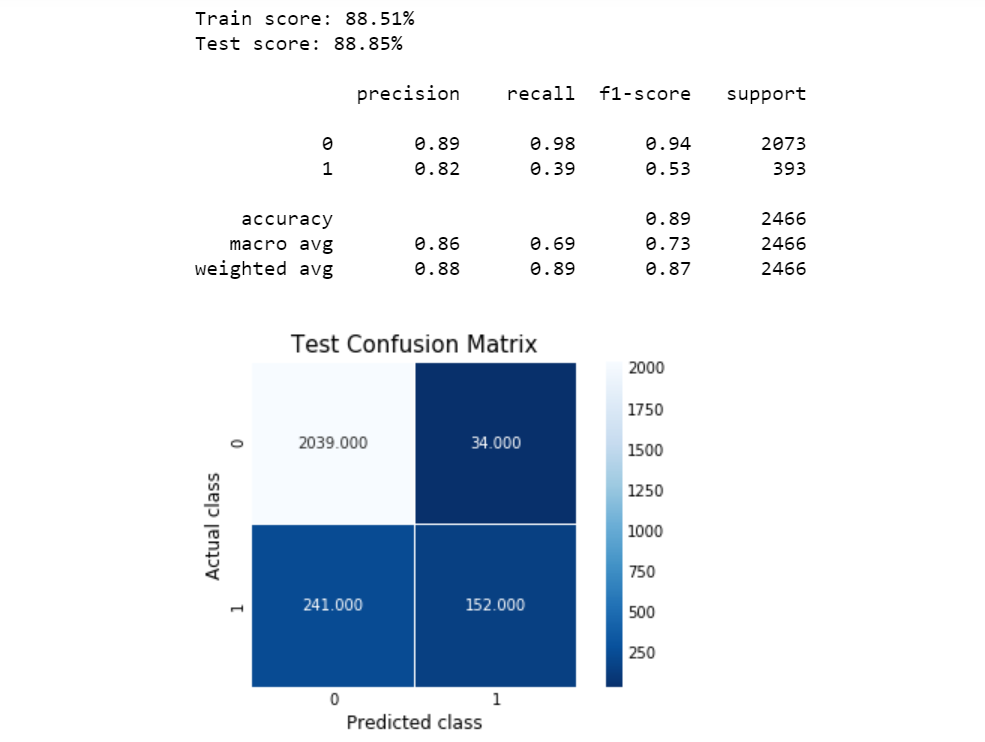

C:\Users\gabri\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Train score: 98.65%
Test score: 84.14%

              precision    recall  f1-score   support

           0       0.84      1.00      0.91      2073
           1       0.60      0.02      0.03       393

    accuracy                           0.84      2466
   macro avg       0.72      0.51      0.47      2466
weighted avg       0.80      0.84      0.77      2466



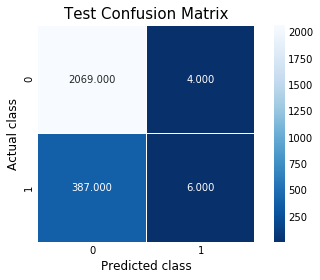

In [22]:
# SUPPORT VECTOR MACHINES
classifier = SVC(kernel='rbf',
                 random_state=1
                )
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)

# METRICS
print(f'Train score: {round(classifier.score(x_train, y_train)*100, 2)}%')
print(f'Test score: {round(classifier.score(x_test, y_test)*100, 2)}%\n')

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Test Confusion Matrix', size = 15)
plt.show()

#### MLP

Train score: 88.64%
Test score: 88.08%

              precision    recall  f1-score   support

           0       0.89      0.98      0.93      2073
           1       0.75      0.38      0.51       393

    accuracy                           0.88      2466
   macro avg       0.82      0.68      0.72      2466
weighted avg       0.87      0.88      0.86      2466



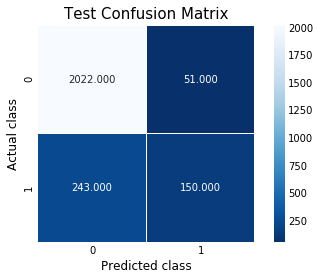

In [23]:
# MLP
classifier = MLPClassifier(hidden_layer_sizes=(100,),
                           activation='relu',
                           solver='adam', 
                           alpha=0.0001, 
                           random_state=1
                          )
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)

# METRICS
print(f'Train score: {round(classifier.score(x_train, y_train)*100, 2)}%')
print(f'Test score: {round(classifier.score(x_test, y_test)*100, 2)}%\n')

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Test Confusion Matrix', size = 15)
plt.show()

Train score: 59.44%
Test score: 60.58%

              precision    recall  f1-score   support

           0       0.87      0.63      0.73      2073
           1       0.20      0.50      0.29       393

    accuracy                           0.61      2466
   macro avg       0.53      0.56      0.51      2466
weighted avg       0.76      0.61      0.66      2466



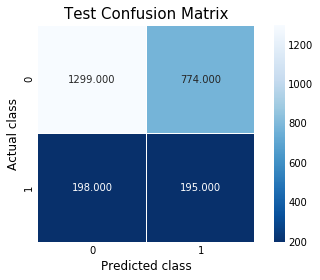

In [24]:
# MLP
classifier = MLPClassifier(hidden_layer_sizes=(100,),
                           activation='relu',
                           solver='lbfgs', 
                           alpha=0.0001, 
                           random_state=1
                          )
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)

# METRICS
print(f'Train score: {round(classifier.score(x_train, y_train)*100, 2)}%')
print(f'Test score: {round(classifier.score(x_test, y_test)*100, 2)}%\n')

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Test Confusion Matrix', size = 15)
plt.show()

## RobustScaler

In [25]:
robust = RobustScaler()
df_robust = pd.DataFrame(robust.fit_transform(df[num_feats]), columns=num_feats)
df_robust = pd.concat([df_robust, df.drop(columns=num_feats)], axis=1)
df_robust.describe()

Administrative  Administrative_Duration  Informational  \
count    12330.000000             12330.000000   12330.000000   
mean         0.328792                 0.786206       0.503569   
std          0.830446                 1.895627       1.270156   
min         -0.250000                -0.080424       0.000000   
25%         -0.250000                -0.080424       0.000000   
50%          0.000000                 0.000000       0.000000   
75%          0.750000                 0.919576       0.000000   
max          6.500000                36.364855      24.000000   

       Informational_Duration  ProductRelated  ProductRelated_Duration  \
count            12330.000000    12330.000000             1.233000e+04   
mean                34.472398        0.442951             4.654689e-01   
std                140.749294        1.434694             1.495031e+00   
min                  0.000000       -0.580645            -4.679123e-01   
25%                  0.000000       -0.354839            -3.240570e-01   
50%                  0.000000        0.000000             4.440824e-17   
75%                  0.000000        0.645161             6.759430e-01   
max               2549.375000       22.161290             4.951063e+01   

        BounceRates     ExitRates    PageValues    SpecialDay  ...  \
count  12330.000000  1.233000e+04  12330.000000  12330.000000  ...   
mean       1.134801  5.016591e-01      5.889258      0.061427  ...   
std        2.884054  1.360703e+00     18.568437      0.198917  ...   
min       -0.185128 -7.043793e-01      0.000000      0.000000  ...   
25%       -0.185128 -3.043793e-01      0.000000      0.000000  ...   
50%        0.000000 -4.857226e-17      0.000000      0.000000  ...   
75%        0.814872  6.956207e-01      0.000000      0.000000  ...   
max       11.710742  4.895621e+00    361.763742      1.000000  ...   

       TrafficType_14  TrafficType_15  TrafficType_16  TrafficType_17  \
count    12330.000000    12330.000000    12330.000000    12330.000000   
mean         0.001054        0.003082        0.000243        0.000081   
std          0.032455        0.055432        0.015597        0.009006   
min          0.000000        0.000000        0.000000        0.000000   
25%          0.000000        0.000000        0.000000        0.000000   
50%          0.000000        0.000000        0.000000        0.000000   
75%          0.000000        0.000000        0.000000        0.000000   
max          1.000000        1.000000        1.000000        1.000000   

       TrafficType_18  TrafficType_19  TrafficType_20  \
count    12330.000000    12330.000000    12330.000000   
mean         0.000811        0.001379        0.016058   
std          0.028468        0.037107        0.125705   
min          0.000000        0.000000        0.000000   
25%          0.000000        0.000000        0.000000   
50%          0.000000        0.000000        0.000000   
75%          0.000000        0.000000        0.000000   
max          1.000000        1.000000        1.000000   

       VisitorType_New_Visitor  VisitorType_Other  \
count             12330.000000       12330.000000   
mean                  0.137388           0.006894   
std                   0.344271           0.082745   
min                   0.000000           0.000000   
25%                   0.000000           0.000000   
50%                   0.000000           0.000000   
75%                   0.000000           0.000000   
max                   1.000000           1.000000   

       VisitorType_Returning_Visitor  
count                   12330.000000  
mean                        0.855718  
std                         0.351390  
min                         0.000000  
25%                         1.000000  
50%                         1.000000  
75%                         1.000000  
max                         1.000000  

[8 rows x 75 columns]

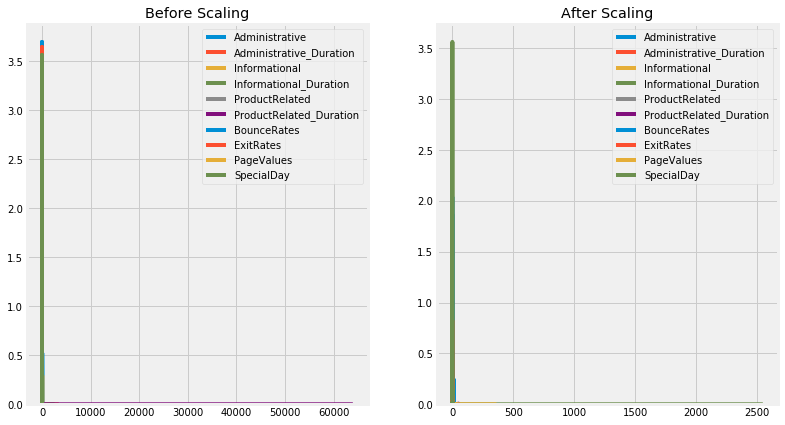

In [26]:
def viz_scaling(ori_dataset, new_dataset, feats):
    '''Function to visualize shape of features' distribution before and after scaling
       ori_dataset  = original dataset name
       new_dataset = new dataset name
       feats = list of features'''
    
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 7))
    
    ax1.set_title('Before Scaling')
    for feat in feats:
        sns.kdeplot(ori_dataset[feat], ax = ax1, bw=0.1)
    
    ax2.set_title('After Scaling')
    for feat in feats:
        sns.kdeplot(new_dataset[feat], ax = ax2, bw=0.1)
    
viz_scaling(df, df_robust, num_feats)    

### Split Train/Test 80/20

In [27]:
X_rob = df_robust.drop(columns='Revenue')
y_rob = df_robust['Revenue']

x_train_rob, x_test_rob, y_train_rob, y_test_rob = train_test_split(X_rob, y_rob, test_size = 0.20,
                                                    random_state = 88)

for data in [x_train_rob, x_test_rob, y_train_rob, y_test_rob]:
    print(data.shape)

(9864, 74)
(2466, 74)
(9864,)
(2466,)


### Spot Check Classification Algorithms

#### LogReg

Train score: 88.5%
Test score: 88.28%

              precision    recall  f1-score   support

           0       0.90      0.97      0.93      2073
           1       0.75      0.40      0.52       393

    accuracy                           0.88      2466
   macro avg       0.82      0.69      0.73      2466
weighted avg       0.87      0.88      0.87      2466



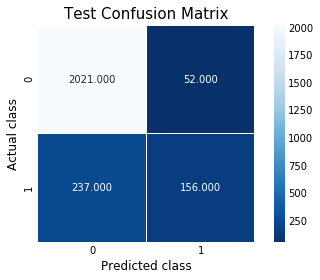

In [28]:
# LOGISTIC REGRESSION
classifier = LogisticRegression(solver='newton-cg',
                                penalty='l2',
                                max_iter=100,
                                random_state=1
                               )
classifier.fit(x_train_rob, y_train_rob)
y_pred_rob = classifier.predict(x_test_rob)

# METRICS
print(f'Train score: {round(classifier.score(x_train_rob, y_train_rob)*100, 2)}%')
print(f'Test score: {round(classifier.score(x_test_rob, y_test_rob)*100, 2)}%\n')

print(classification_report(y_test_rob, y_pred_rob))

cm = confusion_matrix(y_test_rob, y_pred_rob)

sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Test Confusion Matrix', size = 15)
plt.show()

#### DT

Train score: 100.0%
Test score: 87.39%

              precision    recall  f1-score   support

           0       0.93      0.92      0.92      2073
           1       0.60      0.61      0.60       393

    accuracy                           0.87      2466
   macro avg       0.76      0.77      0.76      2466
weighted avg       0.87      0.87      0.87      2466



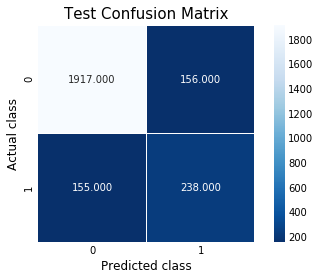

In [29]:
# DECISION TREE
classifier = DecisionTreeClassifier(criterion='gini', 
                                    max_depth=None, 
                                    min_samples_split=2,
                                    min_samples_leaf=1,
                                    random_state=1
                                   )
classifier.fit(x_train_rob, y_train_rob)
y_pred_rob = classifier.predict(x_test_rob)

# METRICS
print(f'Train score: {round(classifier.score(x_train_rob, y_train_rob)*100, 2)}%')
print(f'Test score: {round(classifier.score(x_test_rob, y_test_rob)*100, 2)}%\n')

print(classification_report(y_test_rob, y_pred_rob))

cm = confusion_matrix(y_test_rob, y_pred_rob)

sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Test Confusion Matrix', size = 15)
plt.show()

#### RF

Train score: 100.0%
Test score: 90.47%

              precision    recall  f1-score   support

           0       0.92      0.97      0.94      2073
           1       0.78      0.55      0.65       393

    accuracy                           0.90      2466
   macro avg       0.85      0.76      0.80      2466
weighted avg       0.90      0.90      0.90      2466



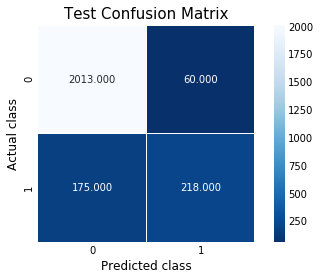

In [30]:
# RANDOM FOREST
classifier = RandomForestClassifier(criterion='gini', 
                                    max_depth=None, 
                                    min_samples_split=2, 
                                    min_samples_leaf=1, 
                                    n_estimators=100,
                                    random_state=1
                                   )
classifier.fit(x_train_rob, y_train_rob)
y_pred_rob = classifier.predict(x_test_rob)

# METRICS
print(f'Train score: {round(classifier.score(x_train_rob, y_train_rob)*100, 2)}%')
print(f'Test score: {round(classifier.score(x_test_rob, y_test_rob)*100, 2)}%\n')

print(classification_report(y_test_rob, y_pred_rob))

cm = confusion_matrix(y_test_rob, y_pred_rob)

sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Test Confusion Matrix', size = 15)
plt.show()

#### KNN

Train score: 91.32%
Test score: 88.73%

              precision    recall  f1-score   support

           0       0.92      0.95      0.93      2073
           1       0.68      0.55      0.61       393

    accuracy                           0.89      2466
   macro avg       0.80      0.75      0.77      2466
weighted avg       0.88      0.89      0.88      2466



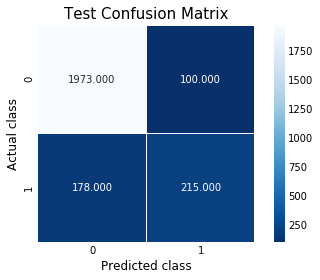

In [31]:
# K NEAREST NEIGHBORS
classifier = KNeighborsClassifier(n_neighbors=5,
                                  algorithm='auto'
                                 )
classifier.fit(x_train_rob, y_train_rob)
y_pred_rob = classifier.predict(x_test_rob)

# METRICS
print(f'Train score: {round(classifier.score(x_train_rob, y_train_rob)*100, 2)}%')
print(f'Test score: {round(classifier.score(x_test_rob, y_test_rob)*100, 2)}%\n')

print(classification_report(y_test_rob, y_pred_rob))

cm = confusion_matrix(y_test_rob, y_pred_rob)

sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Test Confusion Matrix', size = 15)
plt.show()

#### Naive Bayes

Train score: 83.64%
Test score: 84.43%

              precision    recall  f1-score   support

           0       0.93      0.88      0.90      2073
           1       0.51      0.66      0.58       393

    accuracy                           0.84      2466
   macro avg       0.72      0.77      0.74      2466
weighted avg       0.86      0.84      0.85      2466



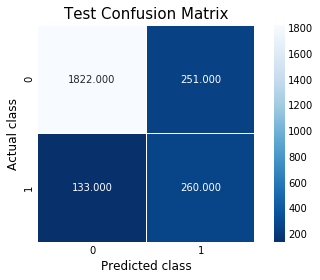

In [32]:
# NAIVE BAYES
classifier = BernoulliNB(alpha=1.0
                       )
classifier.fit(x_train_rob, y_train_rob)
y_pred_rob = classifier.predict(x_test_rob)

# METRICS
print(f'Train score: {round(classifier.score(x_train_rob, y_train_rob)*100, 2)}%')
print(f'Test score: {round(classifier.score(x_test_rob, y_test_rob)*100, 2)}%\n')

print(classification_report(y_test_rob, y_pred_rob))

cm = confusion_matrix(y_test_rob, y_pred_rob)

sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Test Confusion Matrix', size = 15)
plt.show()

#### SVM

Train score: 88.43%
Test score: 88.89%

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      2073
           1       0.78      0.42      0.55       393

    accuracy                           0.89      2466
   macro avg       0.84      0.70      0.74      2466
weighted avg       0.88      0.89      0.87      2466



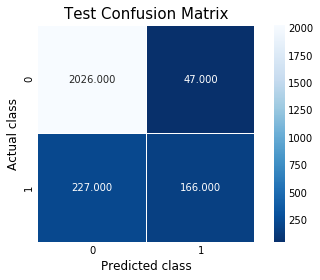

In [33]:
# SUPPORT VECTOR MACHINES
classifier = SVC(kernel='linear',
                 random_state=1
                )
classifier.fit(x_train_rob, y_train_rob)
y_pred_rob = classifier.predict(x_test_rob)

# METRICS
print(f'Train score: {round(classifier.score(x_train_rob, y_train_rob)*100, 2)}%')
print(f'Test score: {round(classifier.score(x_test_rob, y_test_rob)*100, 2)}%\n')

print(classification_report(y_test_rob, y_pred_rob))

cm = confusion_matrix(y_test_rob, y_pred_rob)

sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Test Confusion Matrix', size = 15)
plt.show()

C:\Users\gabri\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Train score: 91.51%
Test score: 89.66%

              precision    recall  f1-score   support

           0       0.92      0.96      0.94      2073
           1       0.73      0.55      0.63       393

    accuracy                           0.90      2466
   macro avg       0.83      0.76      0.78      2466
weighted avg       0.89      0.90      0.89      2466



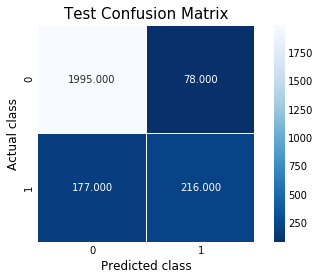

In [34]:
# SUPPORT VECTOR MACHINES
classifier = SVC(kernel='rbf',
                 random_state=1
                )
classifier.fit(x_train_rob, y_train_rob)
y_pred_rob = classifier.predict(x_test_rob)

# METRICS
print(f'Train score: {round(classifier.score(x_train_rob, y_train_rob)*100, 2)}%')
print(f'Test score: {round(classifier.score(x_test_rob, y_test_rob)*100, 2)}%\n')

print(classification_report(y_test_rob, y_pred_rob))

cm = confusion_matrix(y_test_rob, y_pred_rob)

sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Test Confusion Matrix', size = 15)
plt.show()

#### MLP

Train score: 91.47%
Test score: 89.09%

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      2073
           1       0.76      0.47      0.58       393

    accuracy                           0.89      2466
   macro avg       0.83      0.72      0.76      2466
weighted avg       0.88      0.89      0.88      2466



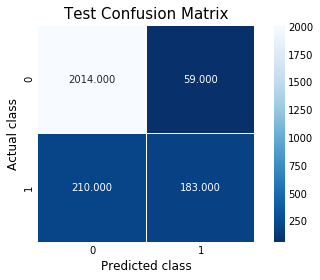

In [35]:
# MLP
classifier = MLPClassifier(hidden_layer_sizes=(100,),
                           activation='relu',
                           solver='adam', 
                           alpha=0.0001, 
                           random_state=1
                          )
classifier.fit(x_train_rob, y_train_rob)
y_pred_rob = classifier.predict(x_test_rob)

# METRICS
print(f'Train score: {round(classifier.score(x_train_rob, y_train_rob)*100, 2)}%')
print(f'Test score: {round(classifier.score(x_test_rob, y_test_rob)*100, 2)}%\n')

print(classification_report(y_test_rob, y_pred_rob))

cm = confusion_matrix(y_test_rob, y_pred_rob)

sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Test Confusion Matrix', size = 15)
plt.show()

Train score: 84.62%
Test score: 84.96%

              precision    recall  f1-score   support

           0       0.85      0.99      0.92      2073
           1       0.67      0.11      0.19       393

    accuracy                           0.85      2466
   macro avg       0.76      0.55      0.55      2466
weighted avg       0.82      0.85      0.80      2466



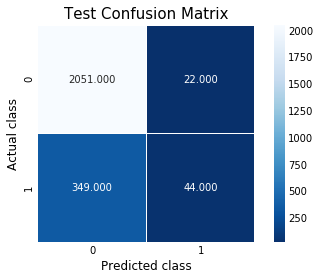

In [36]:
# MLP
classifier = MLPClassifier(hidden_layer_sizes=(100,),
                           activation='relu',
                           solver='lbfgs', 
                           alpha=0.0001, 
                           random_state=1
                          )
classifier.fit(x_train_rob, y_train_rob)
y_pred_rob = classifier.predict(x_test_rob)

# METRICS
print(f'Train score: {round(classifier.score(x_train_rob, y_train_rob)*100, 2)}%')
print(f'Test score: {round(classifier.score(x_test_rob, y_test_rob)*100, 2)}%\n')

print(classification_report(y_test_rob, y_pred_rob))

cm = confusion_matrix(y_test_rob, y_pred_rob)

sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Test Confusion Matrix', size = 15)
plt.show()

## StandardScaler

In [37]:
standard = StandardScaler()
df_standard = pd.DataFrame(standard.fit_transform(df[num_feats]), columns=num_feats)
df_standard = pd.concat([df_standard, df.drop(columns=num_feats)], axis=1)
df_standard.describe()

Administrative  Administrative_Duration  Informational  \
count    1.233000e+04             1.233000e+04   1.233000e+04   
mean    -1.375191e-15             2.074316e-15   6.987391e-15   
std      1.000041e+00             1.000041e+00   1.000041e+00   
min     -6.969930e-01            -4.571914e-01  -3.964779e-01   
25%     -6.969930e-01            -4.571914e-01  -3.964779e-01   
50%     -3.959377e-01            -4.147639e-01  -3.964779e-01   
75%      5.072280e-01             7.035981e-02  -3.964779e-01   
max      7.431499e+00             1.876956e+01   1.849960e+01   

       Informational_Duration  ProductRelated  ProductRelated_Duration  \
count            1.233000e+04    1.233000e+04             1.233000e+04   
mean             1.765777e-16   -2.849753e-16             1.021684e-15   
std              1.000041e+00    1.000041e+00             1.000041e+00   
min             -2.449305e-01   -7.134884e-01            -6.243475e-01   
25%             -2.449305e-01   -5.560920e-01            -5.281214e-01   
50%             -2.449305e-01   -3.087548e-01            -3.113566e-01   
75%             -2.449305e-01    1.409492e-01             1.407881e-01   
max              1.786868e+01    1.513858e+01             3.280678e+01   

        BounceRates     ExitRates    PageValues    SpecialDay  ...  \
count  1.233000e+04  1.233000e+04  1.233000e+04  1.233000e+04  ...   
mean   1.333384e-15 -2.622846e-16 -4.953810e-15 -1.722823e-14  ...   
std    1.000041e+00  1.000041e+00  1.000041e+00  1.000041e+00  ...   
min   -4.576830e-01 -8.863706e-01 -3.171778e-01 -3.088214e-01  ...   
25%   -4.576830e-01 -5.923930e-01 -3.171778e-01 -3.088214e-01  ...   
50%   -3.934903e-01 -3.686913e-01 -3.171778e-01 -3.088214e-01  ...   
75%   -1.109348e-01  1.425510e-01 -3.171778e-01 -3.088214e-01  ...   
max    3.667189e+00  3.229316e+00  1.916634e+01  4.718598e+00  ...   

       TrafficType_14  TrafficType_15  TrafficType_16  TrafficType_17  \
count    12330.000000    12330.000000    12330.000000    12330.000000   
mean         0.001054        0.003082        0.000243        0.000081   
std          0.032455        0.055432        0.015597        0.009006   
min          0.000000        0.000000        0.000000        0.000000   
25%          0.000000        0.000000        0.000000        0.000000   
50%          0.000000        0.000000        0.000000        0.000000   
75%          0.000000        0.000000        0.000000        0.000000   
max          1.000000        1.000000        1.000000        1.000000   

       TrafficType_18  TrafficType_19  TrafficType_20  \
count    12330.000000    12330.000000    12330.000000   
mean         0.000811        0.001379        0.016058   
std          0.028468        0.037107        0.125705   
min          0.000000        0.000000        0.000000   
25%          0.000000        0.000000        0.000000   
50%          0.000000        0.000000        0.000000   
75%          0.000000        0.000000        0.000000   
max          1.000000        1.000000        1.000000   

       VisitorType_New_Visitor  VisitorType_Other  \
count             12330.000000       12330.000000   
mean                  0.137388           0.006894   
std                   0.344271           0.082745   
min                   0.000000           0.000000   
25%                   0.000000           0.000000   
50%                   0.000000           0.000000   
75%                   0.000000           0.000000   
max                   1.000000           1.000000   

       VisitorType_Returning_Visitor  
count                   12330.000000  
mean                        0.855718  
std                         0.351390  
min                         0.000000  
25%                         1.000000  
50%                         1.000000  
75%                         1.000000  
max                         1.000000  

[8 rows x 75 columns]

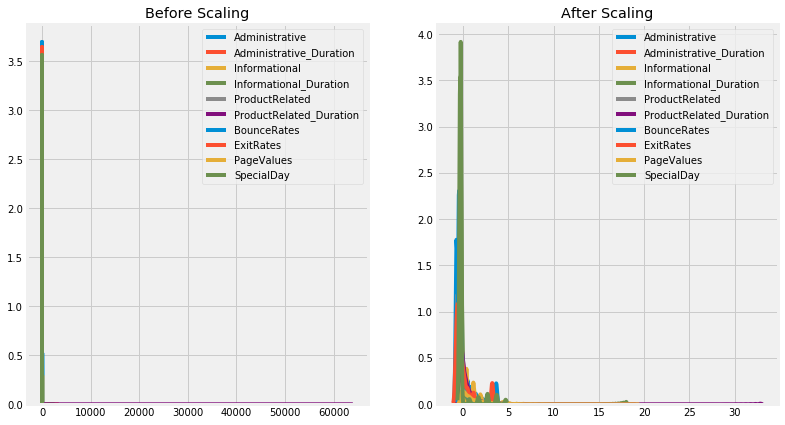

In [38]:
viz_scaling(df, df_standard, num_feats)    

### Split Train/Test 80/20

In [39]:
X_std = df_standard.drop(columns='Revenue')
y_std = df_standard['Revenue']

x_train_std, x_test_std, y_train_std, y_test_std = train_test_split(X_std, y_std, test_size = 0.20,
                                                    random_state = 88)

for data in [x_train_std, x_test_std, y_train_std, y_test_std]:
    print(data.shape)

(9864, 74)
(2466, 74)
(9864,)
(2466,)


### Spot Check Classification Algorithms

#### LogReg

Train score: 88.49%
Test score: 88.28%

              precision    recall  f1-score   support

           0       0.89      0.98      0.93      2073
           1       0.75      0.39      0.52       393

    accuracy                           0.88      2466
   macro avg       0.82      0.68      0.73      2466
weighted avg       0.87      0.88      0.87      2466



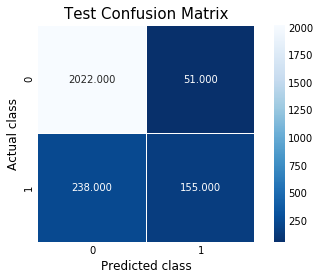

In [40]:
# LOGISTIC REGRESSION
classifier = LogisticRegression(solver='newton-cg',
                                penalty='l2',
                                max_iter=100, 
                                random_state=1
                               )
classifier.fit(x_train_std, y_train_std)
y_pred_std = classifier.predict(x_test_std)

# METRICS
print(f'Train score: {round(classifier.score(x_train_std, y_train_std)*100, 2)}%')
print(f'Test score: {round(classifier.score(x_test_std, y_test_std)*100, 2)}%\n')

print(classification_report(y_test_std, y_pred_std))

cm = confusion_matrix(y_test_std, y_pred_std)

sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Test Confusion Matrix', size = 15)
plt.show()

#### DT

Train score: 100.0%
Test score: 87.43%

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      2073
           1       0.61      0.61      0.61       393

    accuracy                           0.87      2466
   macro avg       0.77      0.77      0.77      2466
weighted avg       0.87      0.87      0.87      2466



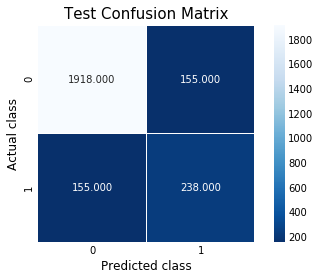

In [41]:
# DECISION TREE
classifier = DecisionTreeClassifier(criterion='gini', 
                                    max_depth=None, 
                                    min_samples_split=2,
                                    min_samples_leaf=1, 
                                    random_state=1
                                   )
classifier.fit(x_train_std, y_train_std)
y_pred_std = classifier.predict(x_test_std)

# METRICS
print(f'Train score: {round(classifier.score(x_train_std, y_train_std)*100, 2)}%')
print(f'Test score: {round(classifier.score(x_test_std, y_test_std)*100, 2)}%\n')

print(classification_report(y_test_std, y_pred_std))

cm = confusion_matrix(y_test_std, y_pred_std)

sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Test Confusion Matrix', size = 15)
plt.show()

#### RF

Train score: 100.0%
Test score: 90.47%

              precision    recall  f1-score   support

           0       0.92      0.97      0.94      2073
           1       0.78      0.55      0.65       393

    accuracy                           0.90      2466
   macro avg       0.85      0.76      0.80      2466
weighted avg       0.90      0.90      0.90      2466



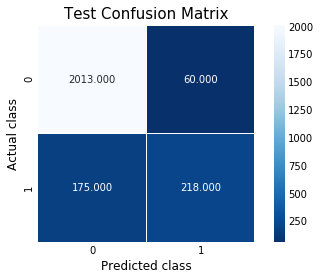

In [42]:
# RANDOM FOREST
classifier = RandomForestClassifier(criterion='gini', 
                                    max_depth=None, 
                                    min_samples_split=2, 
                                    min_samples_leaf=1, 
                                    n_estimators=100, 
                                    random_state=1
                                   )
classifier.fit(x_train_std, y_train_std)
y_pred_std = classifier.predict(x_test_std)

# METRICS
print(f'Train score: {round(classifier.score(x_train_std, y_train_std)*100, 2)}%')
print(f'Test score: {round(classifier.score(x_test_std, y_test_std)*100, 2)}%\n')

print(classification_report(y_test_std, y_pred_std))

cm = confusion_matrix(y_test_std, y_pred_std)

sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Test Confusion Matrix', size = 15)
plt.show()

#### KNN

Train score: 90.17%
Test score: 87.88%

              precision    recall  f1-score   support

           0       0.90      0.97      0.93      2073
           1       0.71      0.40      0.52       393

    accuracy                           0.88      2466
   macro avg       0.80      0.69      0.72      2466
weighted avg       0.87      0.88      0.86      2466



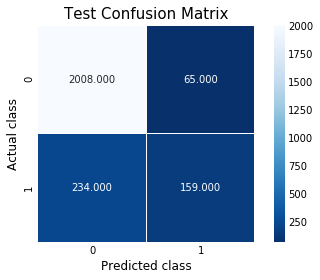

In [43]:
# K NEAREST NEIGHBORS
classifier = KNeighborsClassifier(n_neighbors=5,
                                  algorithm='auto'
                                 )
classifier.fit(x_train_std, y_train_std)
y_pred_std = classifier.predict(x_test_std)

# METRICS
print(f'Train score: {round(classifier.score(x_train_std, y_train_std)*100, 2)}%')
print(f'Test score: {round(classifier.score(x_test_std, y_test_std)*100, 2)}%\n')

print(classification_report(y_test_std, y_pred_std))

cm = confusion_matrix(y_test_std, y_pred_std)

sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Test Confusion Matrix', size = 15)
plt.show()

#### Naive Bayes

Train score: 83.84%
Test score: 85.36%

              precision    recall  f1-score   support

           0       0.93      0.89      0.91      2073
           1       0.53      0.66      0.59       393

    accuracy                           0.85      2466
   macro avg       0.73      0.77      0.75      2466
weighted avg       0.87      0.85      0.86      2466



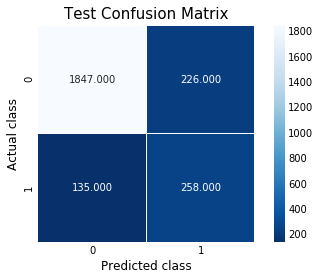

In [44]:
# NAIVE BAYES
classifier = BernoulliNB(alpha=1.0
                       )
classifier.fit(x_train_std, y_train_std)
y_pred_std = classifier.predict(x_test_std)

# METRICS
print(f'Train score: {round(classifier.score(x_train_std, y_train_std)*100, 2)}%')
print(f'Test score: {round(classifier.score(x_test_std, y_test_std)*100, 2)}%\n')

print(classification_report(y_test_std, y_pred_std))

cm = confusion_matrix(y_test_std, y_pred_std)

sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Test Confusion Matrix', size = 15)
plt.show()

#### SVM

Train score: 88.38%
Test score: 88.85%

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      2073
           1       0.78      0.42      0.55       393

    accuracy                           0.89      2466
   macro avg       0.84      0.70      0.74      2466
weighted avg       0.88      0.89      0.87      2466



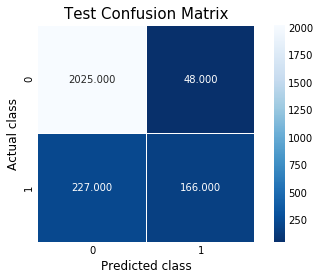

In [45]:
# SUPPORT VECTOR MACHINES
classifier = SVC(kernel='linear', 
                 random_state=1
                )
classifier.fit(x_train_std, y_train_std)
y_pred_std = classifier.predict(x_test_std)

# METRICS
print(f'Train score: {round(classifier.score(x_train_std, y_train_std)*100, 2)}%')
print(f'Test score: {round(classifier.score(x_test_std, y_test_std)*100, 2)}%\n')

print(classification_report(y_test_std, y_pred_std))

cm = confusion_matrix(y_test_std, y_pred_std)

sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Test Confusion Matrix', size = 15)
plt.show()

C:\Users\gabri\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Train score: 89.15%
Test score: 89.62%

              precision    recall  f1-score   support

           0       0.91      0.98      0.94      2073
           1       0.79      0.48      0.59       393

    accuracy                           0.90      2466
   macro avg       0.85      0.73      0.77      2466
weighted avg       0.89      0.90      0.89      2466



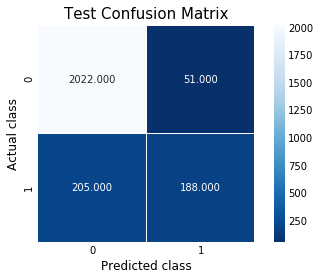

In [46]:
# SUPPORT VECTOR MACHINES
classifier = SVC(kernel='rbf', 
                 random_state=1
                )
classifier.fit(x_train_std, y_train_std)
y_pred_std = classifier.predict(x_test_std)

# METRICS
print(f'Train score: {round(classifier.score(x_train_std, y_train_std)*100, 2)}%')
print(f'Test score: {round(classifier.score(x_test_std, y_test_std)*100, 2)}%\n')

print(classification_report(y_test_std, y_pred_std))

cm = confusion_matrix(y_test_std, y_pred_std)

sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Test Confusion Matrix', size = 15)
plt.show()

#### MLP

Train score: 99.57%
Test score: 87.47%

              precision    recall  f1-score   support

           0       0.92      0.93      0.93      2073
           1       0.61      0.58      0.60       393

    accuracy                           0.87      2466
   macro avg       0.77      0.76      0.76      2466
weighted avg       0.87      0.87      0.87      2466



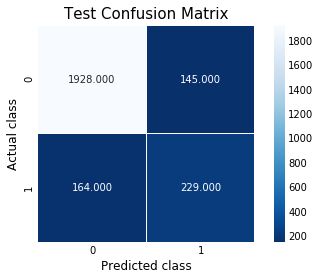

In [47]:
# MLP
classifier = MLPClassifier(hidden_layer_sizes=(100,),
                           activation='relu',
                           solver='adam', 
                           alpha=0.0001, 
                           random_state=1,
                           max_iter=1000  # MODIFIED FROM 200, FAILED TO CONVERGE
                          )
classifier.fit(x_train_std, y_train_std)
y_pred_std = classifier.predict(x_test_std)

# METRICS
print(f'Train score: {round(classifier.score(x_train_std, y_train_std)*100, 2)}%')
print(f'Test score: {round(classifier.score(x_test_std, y_test_std)*100, 2)}%\n')

print(classification_report(y_test_std, y_pred_std))

cm = confusion_matrix(y_test_std, y_pred_std)

sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Test Confusion Matrix', size = 15)
plt.show()

Train score: 99.61%
Test score: 87.19%

              precision    recall  f1-score   support

           0       0.92      0.93      0.92      2073
           1       0.60      0.58      0.59       393

    accuracy                           0.87      2466
   macro avg       0.76      0.75      0.76      2466
weighted avg       0.87      0.87      0.87      2466



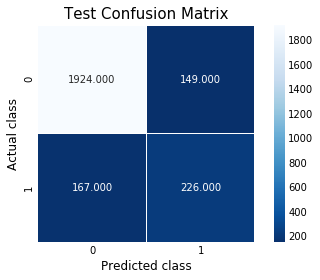

In [48]:
# MLP
classifier = MLPClassifier(hidden_layer_sizes=(100,),
                           activation='relu',
                           solver='lbfgs', 
                           alpha=0.0001, 
                           random_state=1
                          )
classifier.fit(x_train_std, y_train_std)
y_pred_std = classifier.predict(x_test_std)

# METRICS
print(f'Train score: {round(classifier.score(x_train_std, y_train_std)*100, 2)}%')
print(f'Test score: {round(classifier.score(x_test_std, y_test_std)*100, 2)}%\n')

print(classification_report(y_test_std, y_pred_std))

cm = confusion_matrix(y_test_std, y_pred_std)

sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Test Confusion Matrix', size = 15)
plt.show()

## Pick Promising Models

All models saw improvement with scaled data to varying degrees.
Observation: 
- Tree-based models DT & RF,  LogReg, and Naive bayes are not sensitive to scale
- KNN, both SVC models, and both MLP models perform a lot better & faster with scaled data (esp. SVC linear exec. time)

From best scalers with model algorithms:
1. Robust:
    - LogReg
    - RF*
    - KNN*
    - SVM linear
    - SVM rbf*
2. Standard:
    - DT*
    - Naive Bayes*
    - MLP adam*
    - MLP lbfgs*

(*: above average recall 1)

Models with below average recall 1, LogReg & SVC linear, will be eliminated.

## SMOTE Oversampling

Address target imbalance by oversampling the minority (1) class.

All models saw increase in recall 1 most notably KNN & SVM, no changes for MLP adam. The trade-off, however, is decrease in recall 0.

In [49]:
# ROBUST DATA
print('Before SMOTE')
print(Counter(y_train_rob))
for data in [x_train_rob, x_test_rob, y_train_rob, y_test_rob]:
    print(data.shape)

sm = SMOTE(random_state = 7) 
x_train_rob_sm, y_train_rob_sm = sm.fit_sample(x_train_rob, y_train_rob) 
  
print('After SMOTE')
print(Counter(y_train_rob_sm))
for data in [x_train_rob_sm, x_test_rob, y_train_rob_sm, y_test_rob]:
    print(data.shape)

Before SMOTE
Counter({0: 8349, 1: 1515})
(9864, 74)
(2466, 74)
(9864,)
(2466,)
After SMOTE
Counter({1: 8349, 0: 8349})
(16698, 74)
(2466, 74)
(16698,)
(2466,)


In [50]:
# STD DATA
print('Before SMOTE')
print(Counter(y_train_std))
for data in [x_train_std, x_test_std, y_train_std, y_test_std]:
    print(data.shape)

sm = SMOTE(random_state = 7) 
x_train_std_sm, y_train_std_sm = sm.fit_sample(x_train_std, y_train_std) 
  
print('After SMOTE')
print(Counter(y_train_std_sm))
for data in [x_train_std_sm, x_test_std, y_train_std_sm, y_test_std]:
    print(data.shape)

Before SMOTE
Counter({0: 8349, 1: 1515})
(9864, 74)
(2466, 74)
(9864,)
(2466,)
After SMOTE
Counter({1: 8349, 0: 8349})
(16698, 74)
(2466, 74)
(16698,)
(2466,)


### Spot Check Classification Algorithms

#### RF Robust

Train score: 100.0%
Test score: 90.27%

              precision    recall  f1-score   support

           0       0.93      0.96      0.94      2073
           1       0.74      0.60      0.66       393

    accuracy                           0.90      2466
   macro avg       0.83      0.78      0.80      2466
weighted avg       0.90      0.90      0.90      2466



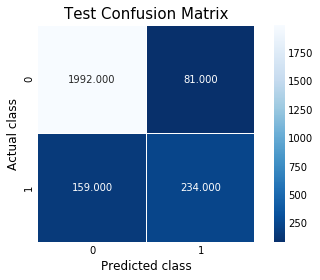

In [51]:
# RANDOM FOREST
classifier = RandomForestClassifier(criterion='gini', 
                                    max_depth=None, 
                                    min_samples_split=2, 
                                    min_samples_leaf=1, 
                                    n_estimators=100,
                                    random_state=1
                                   )
classifier.fit(x_train_rob_sm, y_train_rob_sm)
y_pred_rob_sm = classifier.predict(x_test_rob)

# METRICS
print(f'Train score: {round(classifier.score(x_train_rob_sm, y_train_rob_sm)*100, 2)}%')
print(f'Test score: {round(classifier.score(x_test_rob, y_test_rob)*100, 2)}%\n')

print(classification_report(y_test_rob, y_pred_rob_sm))

cm = confusion_matrix(y_test_rob, y_pred_rob_sm)

sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Test Confusion Matrix', size = 15)
plt.show()

#### KNN Robust

Train score: 91.77%
Test score: 80.54%

              precision    recall  f1-score   support

           0       0.96      0.81      0.87      2073
           1       0.44      0.80      0.57       393

    accuracy                           0.81      2466
   macro avg       0.70      0.80      0.72      2466
weighted avg       0.87      0.81      0.83      2466



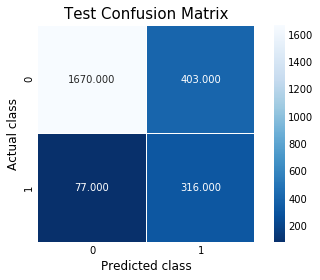

In [52]:
# K NEAREST NEIGHBORS
classifier = KNeighborsClassifier(n_neighbors=5,
                                  algorithm='auto'
                                 )
classifier.fit(x_train_rob_sm, y_train_rob_sm)
y_pred_rob_sm = classifier.predict(x_test_rob)

# METRICS
print(f'Train score: {round(classifier.score(x_train_rob_sm, y_train_rob_sm)*100, 2)}%')
print(f'Test score: {round(classifier.score(x_test_rob, y_test_rob)*100, 2)}%\n')

print(classification_report(y_test_rob, y_pred_rob_sm))

cm = confusion_matrix(y_test_rob, y_pred_rob_sm)

sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Test Confusion Matrix', size = 15)
plt.show()

#### SVM rbf Robust

C:\Users\gabri\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Train score: 88.06%
Test score: 87.23%

              precision    recall  f1-score   support

           0       0.96      0.89      0.92      2073
           1       0.57      0.79      0.66       393

    accuracy                           0.87      2466
   macro avg       0.76      0.84      0.79      2466
weighted avg       0.90      0.87      0.88      2466



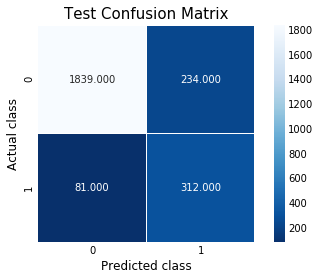

In [53]:
# SUPPORT VECTOR MACHINES
classifier = SVC(kernel='rbf', 
                 random_state=1
                )
classifier.fit(x_train_rob_sm, y_train_rob_sm)
y_pred_rob_sm = classifier.predict(x_test_rob)

# METRICS
print(f'Train score: {round(classifier.score(x_train_rob_sm, y_train_rob_sm)*100, 2)}%')
print(f'Test score: {round(classifier.score(x_test_rob, y_test_rob)*100, 2)}%\n')

print(classification_report(y_test_rob, y_pred_rob_sm))

cm = confusion_matrix(y_test_rob, y_pred_rob_sm)

sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Test Confusion Matrix', size = 15)
plt.show()

#### DT Standard

Train score: 100.0%
Test score: 86.13%

              precision    recall  f1-score   support

           0       0.93      0.90      0.92      2073
           1       0.56      0.64      0.60       393

    accuracy                           0.86      2466
   macro avg       0.74      0.77      0.76      2466
weighted avg       0.87      0.86      0.87      2466



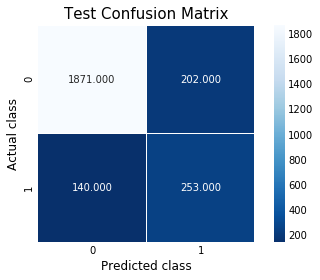

In [54]:
# DECISION TREE
classifier = DecisionTreeClassifier(criterion='gini', 
                                    max_depth=None, 
                                    min_samples_split=2,
                                    min_samples_leaf=1, 
                                    random_state=1
                                   )
classifier.fit(x_train_std_sm, y_train_std_sm)
y_pred_std_sm = classifier.predict(x_test_std)

# METRICS
print(f'Train score: {round(classifier.score(x_train_std_sm, y_train_std_sm)*100, 2)}%')
print(f'Test score: {round(classifier.score(x_test_std, y_test_std)*100, 2)}%\n')

print(classification_report(y_test_std, y_pred_std_sm))

cm = confusion_matrix(y_test_std, y_pred_std_sm)

sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Test Confusion Matrix', size = 15)
plt.show()

#### Naive Bayes Standard

Train score: 81.76%
Test score: 78.06%

              precision    recall  f1-score   support

           0       0.96      0.77      0.86      2073
           1       0.41      0.83      0.55       393

    accuracy                           0.78      2466
   macro avg       0.68      0.80      0.70      2466
weighted avg       0.87      0.78      0.81      2466



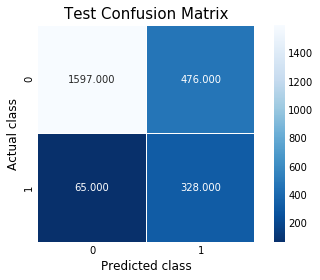

In [55]:
# NAIVE BAYES
classifier = BernoulliNB(alpha=1.0
                       )
classifier.fit(x_train_std_sm, y_train_std_sm)
y_pred_std_sm = classifier.predict(x_test_std)

# METRICS
print(f'Train score: {round(classifier.score(x_train_std_sm, y_train_std_sm)*100, 2)}%')
print(f'Test score: {round(classifier.score(x_test_std, y_test_std)*100, 2)}%\n')

print(classification_report(y_test_std, y_pred_std_sm))

cm = confusion_matrix(y_test_std, y_pred_std_sm)

sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Test Confusion Matrix', size = 15)
plt.show()

#### MLP Standard

Train score: 99.79%
Test score: 87.75%

              precision    recall  f1-score   support

           0       0.92      0.93      0.93      2073
           1       0.63      0.58      0.60       393

    accuracy                           0.88      2466
   macro avg       0.77      0.75      0.76      2466
weighted avg       0.87      0.88      0.88      2466



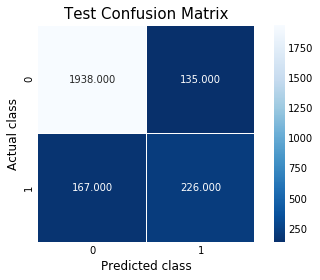

In [56]:
# MLP
classifier = MLPClassifier(hidden_layer_sizes=(100,),
                           activation='relu',
                           solver='adam', 
                           alpha=0.0001, 
                           random_state=1,
                           max_iter=1000  # MODIFIED FROM 200, FAILED TO CONVERGE
                          )
classifier.fit(x_train_std_sm, y_train_std_sm)
y_pred_std_sm = classifier.predict(x_test_std)

# METRICS
print(f'Train score: {round(classifier.score(x_train_std_sm, y_train_std_sm)*100, 2)}%')
print(f'Test score: {round(classifier.score(x_test_std, y_test_std)*100, 2)}%\n')

print(classification_report(y_test_std, y_pred_std_sm))

cm = confusion_matrix(y_test_std, y_pred_std_sm)

sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Test Confusion Matrix', size = 15)
plt.show()

Train score: 99.39%
Test score: 87.39%

              precision    recall  f1-score   support

           0       0.93      0.92      0.92      2073
           1       0.60      0.61      0.61       393

    accuracy                           0.87      2466
   macro avg       0.76      0.77      0.77      2466
weighted avg       0.87      0.87      0.87      2466



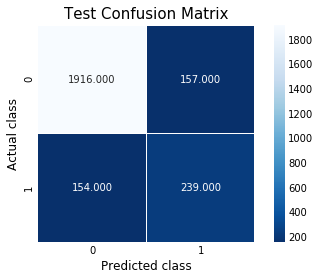

In [57]:
# MLP
classifier = MLPClassifier(hidden_layer_sizes=(100,),
                           activation='relu',
                           solver='lbfgs', 
                           alpha=0.0001, 
                           random_state=1
                          )
classifier.fit(x_train_std_sm, y_train_std_sm)
y_pred_std_sm = classifier.predict(x_test_std)

# METRICS
print(f'Train score: {round(classifier.score(x_train_std_sm, y_train_std_sm)*100, 2)}%')
print(f'Test score: {round(classifier.score(x_test_std, y_test_std)*100, 2)}%\n')

print(classification_report(y_test_std, y_pred_std_sm))

cm = confusion_matrix(y_test_std, y_pred_std_sm)

sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Test Confusion Matrix', size = 15)
plt.show()

## Pick Promising Models

All models saw improvement in recall 1 (average +10% compared to previous), however SMOTE can result in loss of accuracy.
The KNN and Naive Bayes models suffer from decreased test score as much as 9%, thus eliminated.

## Feature Selection
This dataset is fairly high-dimensional (12330 rows × 75 columns). This can lead to slow models and overfitting. Overfitting occurs when a model tries to fit the training data so closely that it does not generalize well to new data (test set). Simple models are also easier to explain (interpretable).

To remedy this problem, number of features can be reduced with various methods. By selecting the most informative features, we hope to achieve the same or even better performance with less inputs.

Note that this differs from dimensionality reduction methods, that may lead to information loss.

### Method

In [58]:
# Number of features

k = 20

In [59]:
X.head()

Administrative  Administrative_Duration  Informational  \
0               0                      0.0              0   
1               0                      0.0              0   
2               0                      0.0              0   
3               0                      0.0              0   
4               0                      0.0              0   

   Informational_Duration  ProductRelated  ProductRelated_Duration  \
0                     0.0               1                 0.000000   
1                     0.0               2                64.000000   
2                     0.0               1                 0.000000   
3                     0.0               2                 2.666667   
4                     0.0              10               627.500000   

   BounceRates  ExitRates  PageValues  SpecialDay  ...  TrafficType_14  \
0         0.20       0.20         0.0         0.0  ...             0.0   
1         0.00       0.10         0.0         0.0  ...             0.0   
2         0.20       0.20         0.0         0.0  ...             0.0   
3         0.05       0.14         0.0         0.0  ...             0.0   
4         0.02       0.05         0.0         0.0  ...             0.0   

   TrafficType_15  TrafficType_16  TrafficType_17  TrafficType_18  \
0             0.0             0.0             0.0             0.0   
1             0.0             0.0             0.0             0.0   
2             0.0             0.0             0.0             0.0   
3             0.0             0.0             0.0             0.0   
4             0.0             0.0             0.0             0.0   

   TrafficType_19  TrafficType_20  VisitorType_New_Visitor  VisitorType_Other  \
0             0.0             0.0                      0.0                0.0   
1             0.0             0.0                      0.0                0.0   
2             0.0             0.0                      0.0                0.0   
3             0.0             0.0                      0.0                0.0   
4             0.0             0.0                      0.0                0.0   

   VisitorType_Returning_Visitor  
0                            1.0  
1                            1.0  
2                            1.0  
3                            1.0  
4                            1.0  

[5 rows x 74 columns]

In [60]:
y

0        0
1        0
2        0
3        0
4        0
        ..
12325    0
12326    0
12327    0
12328    0
12329    0
Name: Revenue, Length: 12330, dtype: int32

#### Filter method
Filter features based on a specified (statistical) metric.

In [61]:
# CORRELATION

def cor_selector(X, y, k):
    cor_list = []
    feature_name = X.columns.tolist()
    
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-k:]].columns.tolist()
    
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature

cor_support, cor_feature = cor_selector(X, y, k)
print(str(len(cor_feature)), 'selected features')
print(cor_feature)

20 selected features
['Month_Mar', 'TrafficType_1', 'TrafficType_13', 'Informational_Duration', 'OperatingSystems_3', 'Month_May', 'SpecialDay', 'TrafficType_3', 'Administrative_Duration', 'Informational', 'VisitorType_Returning_Visitor', 'VisitorType_New_Visitor', 'TrafficType_2', 'Administrative', 'BounceRates', 'ProductRelated_Duration', 'Month_Nov', 'ProductRelated', 'ExitRates', 'PageValues']


In [62]:
pd.set_option('display.max_rows', None)
df.corr()['Revenue'].abs().sort_values(ascending=False)[1:21]

PageValues                       0.492569
ExitRates                        0.207071
ProductRelated                   0.158538
Month_Nov                        0.154774
ProductRelated_Duration          0.152373
BounceRates                      0.150673
Administrative                   0.138917
TrafficType_2                    0.116347
VisitorType_New_Visitor          0.104136
VisitorType_Returning_Visitor    0.103843
Informational                    0.095200
Administrative_Duration          0.093587
TrafficType_3                    0.082808
SpecialDay                       0.082305
Month_May                        0.078320
OperatingSystems_3               0.070472
Informational_Duration           0.070345
TrafficType_13                   0.067310
TrafficType_1                    0.065901
Month_Mar                        0.063941
Name: Revenue, dtype: float64

In [63]:
# CHI2

chi_selector = SelectKBest(chi2, k=k)
chi_selector.fit(X, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')
print(chi_feature)

20 selected features
['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month_Mar', 'Month_May', 'Month_Nov', 'OperatingSystems_3', 'TrafficType_1', 'TrafficType_2', 'TrafficType_3', 'TrafficType_8', 'TrafficType_13', 'VisitorType_New_Visitor']


In [64]:
pd.DataFrame(zip(X.columns.tolist(), chi_selector.scores_),
             columns = ['Feature', 'Score']).nlargest(20, 'Score')

Feature          Score
5   ProductRelated_Duration  877404.339415
8                PageValues  175126.808512
1   Administrative_Duration   41754.836841
3    Informational_Duration   35059.775770
4            ProductRelated   19317.285376
0            Administrative    1133.965531
2             Informational     357.981605
18                Month_Nov     223.548231
71  VisitorType_New_Visitor     115.339482
52            TrafficType_2     113.937321
53            TrafficType_3      70.477528
17                Month_May      54.997108
9                SpecialDay      53.797094
63           TrafficType_13      52.519206
23       OperatingSystems_3      48.546233
51            TrafficType_1      42.903495
16                Month_Mar      42.613274
58            TrafficType_8      39.174150
6               BounceRates      29.654336
7                 ExitRates      28.985072

#### Wrapper method
Use an algorithm to search for the best set of features.

In [65]:
# RECURSIVE FEATURE ELIMINATION

rfe_selector = RFE(estimator=LogisticRegression(), 
                   n_features_to_select=k, 
                   step=10, 
                   verbose=5
                  )
rfe_selector.fit(X, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')
print(rfe_feature)

Fitting estimator with 74 features.


C:\Users\gabri\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 64 features.
Fitting estimator with 54 features.
Fitting estimator with 44 features.
Fitting estimator with 34 features.


C:\Users\gabri\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\gabri\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\gabri\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\gabri\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting estimator with 24 features.
20 selected features
['BounceRates', 'ExitRates', 'SpecialDay', 'Month_Dec', 'Month_Feb', 'Month_June', 'Month_Mar', 'Month_May', 'Month_Nov', 'OperatingSystems_3', 'Browser_3', 'Browser_12', 'TrafficType_1', 'TrafficType_3', 'TrafficType_6', 'TrafficType_7', 'TrafficType_13', 'TrafficType_15', 'TrafficType_18', 'TrafficType_19']


C:\Users\gabri\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\gabri\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


#### Embedded method
Use an algorithm that has built-in (embedded) feature selection method.

In [66]:
# EMBEDDED RANDOM FOREST FEATURE IMPORTANCE

embedded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), 
                                       max_features=k
                                      )
embedded_rf_selector.fit(X, y)
embedded_rf_support = embedded_rf_selector.get_support()
embedded_rf_feature = X.loc[:,embedded_rf_support].columns.tolist()
print(str(len(embedded_rf_feature)), 'selected features')
embedded_rf_feature

10 selected features


['Administrative',
 'Administrative_Duration',
 'Informational',
 'Informational_Duration',
 'ProductRelated',
 'ProductRelated_Duration',
 'BounceRates',
 'ExitRates',
 'PageValues',
 'Month_Nov']

### Result

Observations:
- Correlation & Chi2 selector almost 100% agree with each other
- RFE selector is the odd one out
- All numerical features are selected in final top 20 tally, particularly preferred by embedded RF selector

VisitorType_Returning_Visitor is selected as the 20th feature from tied tally.

In [67]:
# pd.set_option('display.max_rows', None)

feature_selection_df = pd.DataFrame({'Feature':X.columns.tolist(), 'Corr':cor_support, 'Chi-2':chi_support, 
                                     'RFE':rfe_support, 'Random Forest':embedded_rf_support})
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)

feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(0, len(feature_selection_df))
feature_selection_df

Feature   Corr  Chi-2    RFE  Random Forest  Total
0                       Month_Nov   True   True   True           True      4
1                       ExitRates   True   True   True           True      4
2                     BounceRates   True   True   True           True      4
3                   TrafficType_3   True   True   True          False      3
4                  TrafficType_13   True   True   True          False      3
5                   TrafficType_1   True   True   True          False      3
6                      SpecialDay   True   True   True          False      3
7         ProductRelated_Duration   True   True  False           True      3
8                  ProductRelated   True   True  False           True      3
9                      PageValues   True   True  False           True      3
10             OperatingSystems_3   True   True   True          False      3
11                      Month_May   True   True   True          False      3
12                      Month_Mar   True   True   True          False      3
13         Informational_Duration   True   True  False           True      3
14                  Informational   True   True  False           True      3
15        Administrative_Duration   True   True  False           True      3
16                 Administrative   True   True  False           True      3
17        VisitorType_New_Visitor   True   True  False          False      2
18                  TrafficType_2   True   True  False          False      2
19  VisitorType_Returning_Visitor   True  False  False          False      1
20                  TrafficType_8  False   True  False          False      1
21                  TrafficType_7  False  False   True          False      1
22                  TrafficType_6  False  False   True          False      1
23                 TrafficType_19  False  False   True          False      1
24                 TrafficType_18  False  False   True          False      1
25                 TrafficType_15  False  False   True          False      1
26                     Month_June  False  False   True          False      1
27                      Month_Feb  False  False   True          False      1
28                      Month_Dec  False  False   True          False      1
29                      Browser_3  False  False   True          False      1
30                     Browser_12  False  False   True          False      1
31                        Weekend  False  False  False          False      0
32              VisitorType_Other  False  False  False          False      0
33                  TrafficType_9  False  False  False          False      0
34                  TrafficType_5  False  False  False          False      0
35                  TrafficType_4  False  False  False          False      0
36                 TrafficType_20  False  False  False          False      0
37                 TrafficType_17  False  False  False          False      0
38                 TrafficType_16  False  False  False          False      0
39                 TrafficType_14  False  False  False          False      0
40                 TrafficType_12  False  False  False          False      0
41                 TrafficType_11  False  False  False          False      0
42                 TrafficType_10  False  False  False          False      0
43                       Region_9  False  False  False          False      0
44                       Region_8  False  False  False          False      0
45                       Region_7  False  False  False          False      0
46                       Region_6  False  False  False          False      0
47                       Region_5  False  False  False          False      0
48                       Region_4  False  False  False          False      0
49                       Region_3  False  False  False          False      0
50                       Region_2  False  False  False          False      0
51                    

In [68]:
pd.set_option('display.max_rows', 10)

In [69]:
sel_feats = [feat for feat in feature_selection_df[:20]['Feature']]
sel_feats

['Month_Nov',
 'ExitRates',
 'BounceRates',
 'TrafficType_3',
 'TrafficType_13',
 'TrafficType_1',
 'SpecialDay',
 'ProductRelated_Duration',
 'ProductRelated',
 'PageValues',
 'OperatingSystems_3',
 'Month_May',
 'Month_Mar',
 'Informational_Duration',
 'Informational',
 'Administrative_Duration',
 'Administrative',
 'VisitorType_New_Visitor',
 'TrafficType_2',
 'VisitorType_Returning_Visitor']

### Split Train/Test 80/20

In [70]:
X_rob_sel = df_robust[sel_feats]
y_rob_sel = df_robust['Revenue']

x_train_rob_sel, x_test_rob_sel, y_train_rob_sel, y_test_rob_sel = train_test_split(X_rob_sel, 
                                                                                    y_rob_sel, 
                                                                                    test_size = 0.20, 
                                                                                    random_state = 88
                                                                                   )

sm = SMOTE(random_state = 7)
x_train_rob_sel_sm, y_train_rob_sel_sm = sm.fit_sample(x_train_rob_sel, y_train_rob_sel) 

print(Counter(y_train_rob_sel_sm))
for data in [x_train_rob_sel_sm, x_test_rob_sel, y_train_rob_sel_sm, y_test_rob_sel]:
    print(data.shape)

Counter({1: 8349, 0: 8349})
(16698, 20)
(2466, 20)
(16698,)
(2466,)


In [71]:
X_std_sel = df_standard[sel_feats]
y_std_sel = df_standard['Revenue']

x_train_std_sel, x_test_std_sel, y_train_std_sel, y_test_std_sel = train_test_split(X_std_sel, 
                                                                                    y_std_sel, 
                                                                                    test_size = 0.20, 
                                                                                    random_state = 88
                                                                                   )

sm = SMOTE(random_state = 7) 
x_train_std_sel_sm, y_train_std_sel_sm = sm.fit_sample(x_train_std_sel, y_train_std_sel) 

print(Counter(y_train_std_sel_sm))
for data in [x_train_std_sel_sm, x_test_std_sel, y_train_std_sel_sm, y_test_std_sel]:
    print(data.shape)

Counter({1: 8349, 0: 8349})
(16698, 20)
(2466, 20)
(16698,)
(2466,)


### Spot Check Classification Algorithms

#### RF Robust

Train score: 100.0%
Test score: 90.06%

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      2073
           1       0.69      0.69      0.69       393

    accuracy                           0.90      2466
   macro avg       0.81      0.82      0.82      2466
weighted avg       0.90      0.90      0.90      2466



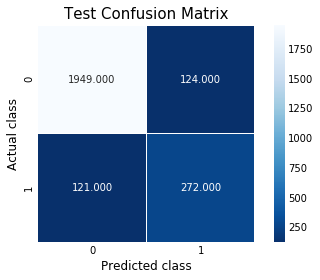

In [72]:
# RANDOM FOREST
classifier = RandomForestClassifier(criterion='gini', 
                                    max_depth=None, 
                                    min_samples_split=2, 
                                    min_samples_leaf=1, 
                                    n_estimators=100,
                                    random_state=1
                                   )
classifier.fit(x_train_rob_sel_sm, y_train_rob_sel_sm)
y_pred_rob_sel_sm = classifier.predict(x_test_rob_sel)

# METRICS
print(f'Train score: {round(classifier.score(x_train_rob_sel_sm, y_train_rob_sel_sm)*100, 2)}%')
print(f'Test score: {round(classifier.score(x_test_rob_sel, y_test_rob_sel)*100, 2)}%\n')

print(classification_report(y_test_rob_sel, y_pred_rob_sel_sm))

cm = confusion_matrix(y_test_rob_sel, y_pred_rob_sel_sm)

sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Test Confusion Matrix', size = 15)
plt.show()

In [73]:
pd.DataFrame(zip(sel_feats, classifier.feature_importances_),
             columns = ['Feature', 'Importance']).nlargest(20, 'Importance')

Feature  Importance
9                      PageValues    0.341091
1                       ExitRates    0.083866
16                 Administrative    0.080893
0                       Month_Nov    0.073490
7         ProductRelated_Duration    0.068897
..                            ...         ...
3                   TrafficType_3    0.012417
19  VisitorType_Returning_Visitor    0.011592
17        VisitorType_New_Visitor    0.010766
4                  TrafficType_13    0.004428
6                      SpecialDay    0.003114

[20 rows x 2 columns]

#### SVM rbf Robust

C:\Users\gabri\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Train score: 89.95%
Test score: 86.98%

              precision    recall  f1-score   support

           0       0.96      0.89      0.92      2073
           1       0.57      0.79      0.66       393

    accuracy                           0.87      2466
   macro avg       0.76      0.84      0.79      2466
weighted avg       0.89      0.87      0.88      2466



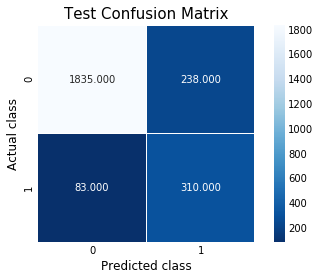

In [74]:
# SUPPORT VECTOR MACHINES
classifier = SVC(kernel='rbf', 
                 random_state=1
                )
classifier.fit(x_train_rob_sel_sm, y_train_rob_sel_sm)
y_pred_rob_sel_sm = classifier.predict(x_test_rob_sel)

# METRICS
print(f'Train score: {round(classifier.score(x_train_rob_sel_sm, y_train_rob_sel_sm)*100, 2)}%')
print(f'Test score: {round(classifier.score(x_test_rob_sel, y_test_rob_sel)*100, 2)}%\n')

print(classification_report(y_test_rob_sel, y_pred_rob_sel_sm))

cm = confusion_matrix(y_test_rob_sel, y_pred_rob_sel_sm)

sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Test Confusion Matrix', size = 15)
plt.show()

#### DT Standard

Train score: 100.0%
Test score: 86.29%

              precision    recall  f1-score   support

           0       0.93      0.91      0.92      2073
           1       0.56      0.61      0.59       393

    accuracy                           0.86      2466
   macro avg       0.74      0.76      0.75      2466
weighted avg       0.87      0.86      0.87      2466



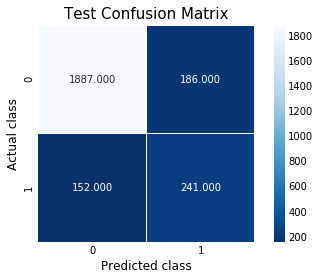

In [75]:
# DECISION TREE
classifier = DecisionTreeClassifier(criterion='gini', 
                                    max_depth=None, 
                                    min_samples_split=2,
                                    min_samples_leaf=1, 
                                    random_state=1
                                   )
classifier.fit(x_train_std_sel_sm, y_train_std_sel_sm)
y_pred_std_sel_sm = classifier.predict(x_test_std_sel)

# METRICS
print(f'Train score: {round(classifier.score(x_train_std_sel_sm, y_train_std_sel_sm)*100, 2)}%')
print(f'Test score: {round(classifier.score(x_test_std_sel, y_test_std_sel)*100, 2)}%\n')

print(classification_report(y_test_std_sel, y_pred_std_sel_sm))

cm = confusion_matrix(y_test_std_sel, y_pred_std_sel_sm)

sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Test Confusion Matrix', size = 15)
plt.show()

#### MLP Standard

Train score: 95.28%
Test score: 88.0%

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      2073
           1       0.61      0.68      0.65       393

    accuracy                           0.88      2466
   macro avg       0.77      0.80      0.79      2466
weighted avg       0.89      0.88      0.88      2466



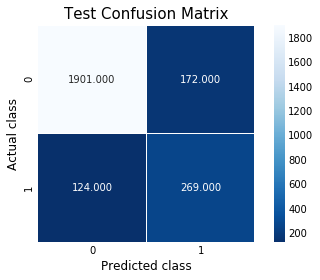

In [76]:
# MLP
classifier = MLPClassifier(hidden_layer_sizes=(100,),
                           activation='relu',
                           solver='adam', 
                           alpha=0.0001, 
                           random_state=1,
                           max_iter=1000  # MODIFIED FROM 200, FAILED TO CONVERGE
                          )
classifier.fit(x_train_std_sel_sm, y_train_std_sel_sm)
y_pred_std_sel_sm = classifier.predict(x_test_std_sel)

# METRICS
print(f'Train score: {round(classifier.score(x_train_std_sel_sm, y_train_std_sel_sm)*100, 2)}%')
print(f'Test score: {round(classifier.score(x_test_std_sel, y_test_std_sel)*100, 2)}%\n')

print(classification_report(y_test_std_sel, y_pred_std_sel_sm))

cm = confusion_matrix(y_test_std_sel, y_pred_std_sel_sm)

sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Test Confusion Matrix', size = 15)
plt.show()

Train score: 94.32%
Test score: 87.02%

              precision    recall  f1-score   support

           0       0.95      0.89      0.92      2073
           1       0.57      0.74      0.65       393

    accuracy                           0.87      2466
   macro avg       0.76      0.82      0.78      2466
weighted avg       0.89      0.87      0.88      2466



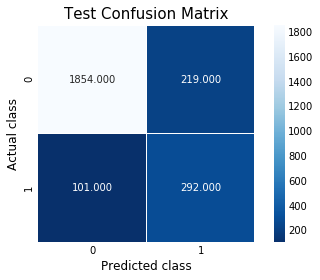

In [77]:
# MLP
classifier = MLPClassifier(hidden_layer_sizes=(100,),
                           activation='relu',
                           solver='lbfgs', 
                           alpha=0.0001, 
                           random_state=1
                          )
classifier.fit(x_train_std_sel_sm, y_train_std_sel_sm)
y_pred_std_sel_sm = classifier.predict(x_test_std_sel)

# METRICS
print(f'Train score: {round(classifier.score(x_train_std_sel_sm, y_train_std_sel_sm)*100, 2)}%')
print(f'Test score: {round(classifier.score(x_test_std_sel, y_test_std_sel)*100, 2)}%\n')

print(classification_report(y_test_std_sel, y_pred_std_sel_sm))

cm = confusion_matrix(y_test_std_sel, y_pred_std_sel_sm)

sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Test Confusion Matrix', size = 15)
plt.show()

### Eliminate Multicollinearity
Remove highly correlated features

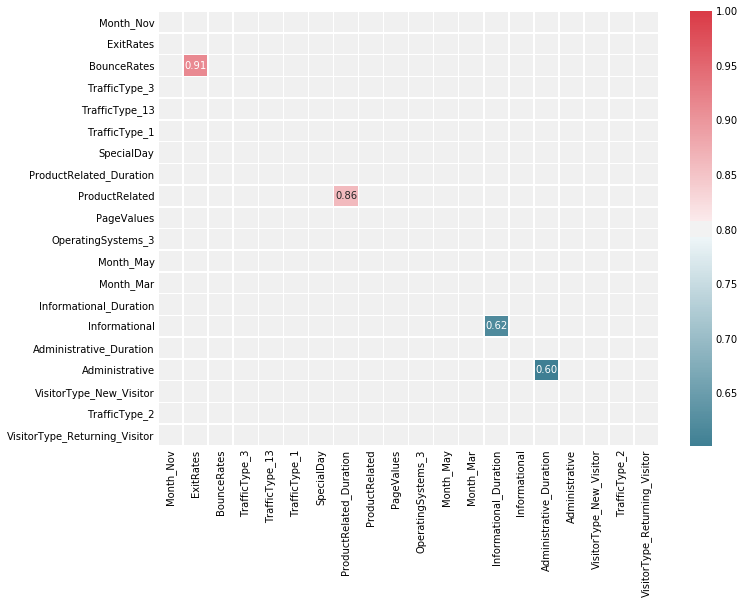

In [134]:
corr = df[sel_feats].corr()
fig, ax = plt.subplots(figsize=(10, 8))
colormap = sns.diverging_palette(220, 10, as_cmap=True)
dropSelf = np.zeros_like(corr)
dropSelf[np.triu_indices_from(dropSelf)] = True
sns.heatmap(corr.where(corr>0.5), cmap=colormap, linewidths=.5, annot=True, fmt=".2f", mask=dropSelf)
plt.show()

In [79]:
sel_feats_2 = ['Month_Nov',
#                'ExitRates',
               'BounceRates',
               'TrafficType_3',
               'TrafficType_13',
               'TrafficType_1',
               'SpecialDay',
               'ProductRelated_Duration',
#                'ProductRelated',
               'PageValues',
               'OperatingSystems_3',
               'Month_May',
               'Month_Mar',
               'Informational_Duration',
#                'Informational',
               'Administrative_Duration',
#                'Administrative',
               'VisitorType_New_Visitor',
               'TrafficType_2',
               'VisitorType_Returning_Visitor'
              ]

### Split Train/Test 80/20

In [80]:
X_rob_sel_2 = df_robust[sel_feats_2]
y_rob_sel_2 = df_robust['Revenue']

x_train_rob_sel_2, x_test_rob_sel_2, y_train_rob_sel_2, y_test_rob_sel_2 = train_test_split(X_rob_sel_2, 
                                                                                    y_rob_sel_2, 
                                                                                    test_size = 0.20, 
                                                                                    random_state = 88
                                                                                   )

sm = SMOTE(random_state = 7)
x_train_rob_sel_2_sm, y_train_rob_sel_2_sm = sm.fit_sample(x_train_rob_sel_2, y_train_rob_sel_2) 

print(Counter(y_train_rob_sel_2_sm))
for data in [x_train_rob_sel_2_sm, x_test_rob_sel_2, y_train_rob_sel_2_sm, y_test_rob_sel_2]:
    print(data.shape)

Counter({1: 8349, 0: 8349})
(16698, 16)
(2466, 16)
(16698,)
(2466,)


In [81]:
X_std_sel_2 = df_standard[sel_feats_2]
y_std_sel_2 = df_standard['Revenue']

x_train_std_sel_2, x_test_std_sel_2, y_train_std_sel_2, y_test_std_sel_2 = train_test_split(X_std_sel_2, 
                                                                                    y_std_sel_2, 
                                                                                    test_size = 0.20, 
                                                                                    random_state = 88
                                                                                   )

sm = SMOTE(random_state = 7) 
x_train_std_sel_2_sm, y_train_std_sel_2_sm = sm.fit_sample(x_train_std_sel_2, y_train_std_sel_2) 

print(Counter(y_train_std_sel_2_sm))
for data in [x_train_std_sel_2_sm, x_test_std_sel_2, y_train_std_sel_2_sm, y_test_std_sel_2]:
    print(data.shape)

Counter({1: 8349, 0: 8349})
(16698, 16)
(2466, 16)
(16698,)
(2466,)


### Spot Check Classification Algorithms

#### RF Robust

Train score: 99.99%
Test score: 88.52%

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      2073
           1       0.63      0.69      0.66       393

    accuracy                           0.89      2466
   macro avg       0.78      0.80      0.79      2466
weighted avg       0.89      0.89      0.89      2466



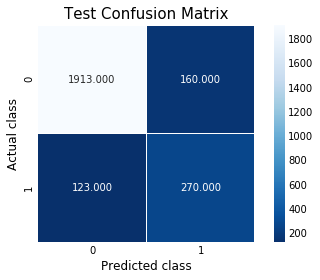

In [82]:
# RANDOM FOREST
classifier = RandomForestClassifier(criterion='gini', 
                                    max_depth=None, 
                                    min_samples_split=2, 
                                    min_samples_leaf=1, 
                                    n_estimators=100,
                                    random_state=1
                                   )
classifier.fit(x_train_rob_sel_2_sm, y_train_rob_sel_2_sm)
y_pred_rob_sel_2_sm = classifier.predict(x_test_rob_sel_2)

# METRICS
print(f'Train score: {round(classifier.score(x_train_rob_sel_2_sm, y_train_rob_sel_2_sm)*100, 2)}%')
print(f'Test score: {round(classifier.score(x_test_rob_sel_2, y_test_rob_sel_2)*100, 2)}%\n')

print(classification_report(y_test_rob_sel_2, y_pred_rob_sel_2_sm))

cm = confusion_matrix(y_test_rob_sel_2, y_pred_rob_sel_2_sm)

sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Test Confusion Matrix', size = 15)
plt.show()

In [83]:
pd.DataFrame(zip(sel_feats_2, classifier.feature_importances_),
             columns = ['Feature', 'Importance']).nlargest(16, 'Importance')

Feature  Importance
7                      PageValues    0.394256
6         ProductRelated_Duration    0.127138
12        Administrative_Duration    0.117232
1                     BounceRates    0.081795
0                       Month_Nov    0.073853
..                            ...         ...
4                   TrafficType_1    0.015686
15  VisitorType_Returning_Visitor    0.012176
13        VisitorType_New_Visitor    0.011446
3                  TrafficType_13    0.005870
5                      SpecialDay    0.003663

[16 rows x 2 columns]

#### SVM rbf Robust

C:\Users\gabri\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Train score: 89.17%
Test score: 86.74%

              precision    recall  f1-score   support

           0       0.96      0.88      0.92      2073
           1       0.56      0.80      0.66       393

    accuracy                           0.87      2466
   macro avg       0.76      0.84      0.79      2466
weighted avg       0.90      0.87      0.88      2466



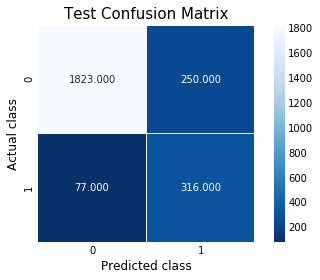

In [84]:
# SUPPORT VECTOR MACHINES
classifier = SVC(kernel='rbf', 
                 random_state=1
                )
classifier.fit(x_train_rob_sel_2_sm, y_train_rob_sel_2_sm)
y_pred_rob_sel_2_sm = classifier.predict(x_test_rob_sel_2)

# METRICS
print(f'Train score: {round(classifier.score(x_train_rob_sel_2_sm, y_train_rob_sel_2_sm)*100, 2)}%')
print(f'Test score: {round(classifier.score(x_test_rob_sel_2, y_test_rob_sel_2)*100, 2)}%\n')

print(classification_report(y_test_rob_sel_2, y_pred_rob_sel_2_sm))

cm = confusion_matrix(y_test_rob_sel_2, y_pred_rob_sel_2_sm)

sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Test Confusion Matrix', size = 15)
plt.show()

#### DT Standard

Train score: 99.99%
Test score: 84.55%

              precision    recall  f1-score   support

           0       0.93      0.88      0.91      2073
           1       0.51      0.65      0.57       393

    accuracy                           0.85      2466
   macro avg       0.72      0.77      0.74      2466
weighted avg       0.86      0.85      0.85      2466



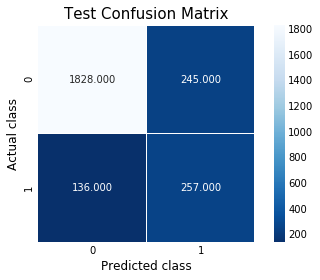

In [85]:
# DECISION TREE
classifier = DecisionTreeClassifier(criterion='gini', 
                                    max_depth=None, 
                                    min_samples_split=2,
                                    min_samples_leaf=1, 
                                    random_state=1
                                   )
classifier.fit(x_train_std_sel_2_sm, y_train_std_sel_2_sm)
y_pred_std_sel_2_sm = classifier.predict(x_test_std_sel_2)

# METRICS
print(f'Train score: {round(classifier.score(x_train_std_sel_2_sm, y_train_std_sel_2_sm)*100, 2)}%')
print(f'Test score: {round(classifier.score(x_test_std_sel_2, y_test_std_sel_2)*100, 2)}%\n')

print(classification_report(y_test_std_sel_2, y_pred_std_sel_2_sm))

cm = confusion_matrix(y_test_std_sel_2, y_pred_std_sel_2_sm)

sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Test Confusion Matrix', size = 15)
plt.show()

#### MLP Standard

Train score: 90.77%
Test score: 86.37%

              precision    recall  f1-score   support

           0       0.96      0.88      0.92      2073
           1       0.55      0.80      0.65       393

    accuracy                           0.86      2466
   macro avg       0.75      0.84      0.78      2466
weighted avg       0.89      0.86      0.87      2466



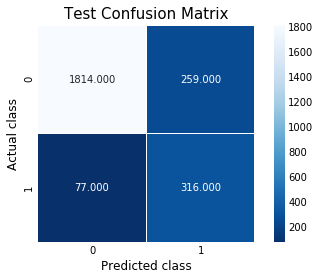

In [86]:
# MLP
classifier = MLPClassifier(hidden_layer_sizes=(100,),
                           activation='relu',
                           solver='adam', 
                           alpha=0.0001, 
                           random_state=1,
                           max_iter=1000  # MODIFIED FROM 200, FAILED TO CONVERGE
                          )
classifier.fit(x_train_std_sel_2_sm, y_train_std_sel_2_sm)
y_pred_std_sel_2_sm = classifier.predict(x_test_std_sel_2)

# METRICS
print(f'Train score: {round(classifier.score(x_train_std_sel_2_sm, y_train_std_sel_2_sm)*100, 2)}%')
print(f'Test score: {round(classifier.score(x_test_std_sel_2, y_test_std_sel_2)*100, 2)}%\n')

print(classification_report(y_test_std_sel_2, y_pred_std_sel_2_sm))

cm = confusion_matrix(y_test_std_sel_2, y_pred_std_sel_2_sm)

sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Test Confusion Matrix', size = 15)
plt.show()

Train score: 91.27%
Test score: 86.74%

              precision    recall  f1-score   support

           0       0.95      0.88      0.92      2073
           1       0.56      0.78      0.65       393

    accuracy                           0.87      2466
   macro avg       0.76      0.83      0.78      2466
weighted avg       0.89      0.87      0.88      2466



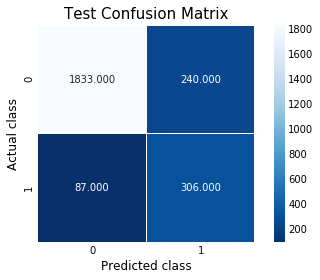

In [87]:
# MLP
classifier = MLPClassifier(hidden_layer_sizes=(100,),
                           activation='relu',
                           solver='lbfgs', 
                           alpha=0.0001, 
                           random_state=1
                          )
classifier.fit(x_train_std_sel_2_sm, y_train_std_sel_2_sm)
y_pred_std_sel_2_sm = classifier.predict(x_test_std_sel_2)

# METRICS
print(f'Train score: {round(classifier.score(x_train_std_sel_2_sm, y_train_std_sel_2_sm)*100, 2)}%')
print(f'Test score: {round(classifier.score(x_test_std_sel_2, y_test_std_sel_2)*100, 2)}%\n')

print(classification_report(y_test_std_sel_2, y_pred_std_sel_2_sm))

cm = confusion_matrix(y_test_std_sel_2, y_pred_std_sel_2_sm)

sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Test Confusion Matrix', size = 15)
plt.show()

## Pick Promising Models

All models saw improvement in recall 1 with 20 selected features (average +10% compared to 74 features), and the improvement is even more amplified when multicollinearity is eliminated down to 16 features (average +16% compared to 74 features). Trade-off with test score is small to none.

DT's metrics are behind other models and will be eliminated. For MLP adam solver will be chosen over lbfgs.

## Hyperparameter Tuning

### RF Robust
Found best params by random search {'n_estimators': 80,
 'min_samples_split': 4,
 'min_samples_leaf': 1,
 'max_depth': 200,
 'criterion': 'entropy'}
 
Recall 1 successfully increased by 4% compared to before tuning, as well as test score +1%

#### Base

Train score: 99.99%
Test score: 88.52%

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      2073
           1       0.63      0.69      0.66       393

    accuracy                           0.89      2466
   macro avg       0.78      0.80      0.79      2466
weighted avg       0.89      0.89      0.89      2466



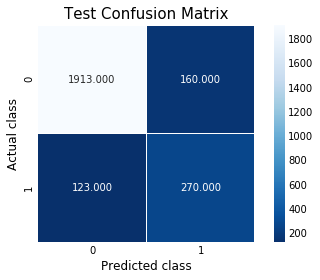

In [88]:
# RANDOM FOREST
classifier = RandomForestClassifier(criterion='gini', 
                                    max_depth=None, 
                                    min_samples_split=2, 
                                    min_samples_leaf=1, 
                                    n_estimators=100,
                                    random_state=1
                                   )
classifier.fit(x_train_rob_sel_2_sm, y_train_rob_sel_2_sm)
y_pred_rob_sel_2_sm = classifier.predict(x_test_rob_sel_2)

# METRICS
print(f'Train score: {round(classifier.score(x_train_rob_sel_2_sm, y_train_rob_sel_2_sm)*100, 2)}%')
print(f'Test score: {round(classifier.score(x_test_rob_sel_2, y_test_rob_sel_2)*100, 2)}%\n')

print(classification_report(y_test_rob_sel_2, y_pred_rob_sel_2_sm))

cm = confusion_matrix(y_test_rob_sel_2, y_pred_rob_sel_2_sm)

sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Test Confusion Matrix', size = 15)
plt.show()

#### Random Search

In [89]:
rf_param_rand = {'criterion' : ['gini', 'entropy'],
                 'max_depth' : [None, 10, 20, 40, 80, 100, 200, 400],
                 'min_samples_split' : [2, 3, 4, 5, 6, 7, 8, 9, 10],
                 'min_samples_leaf' : [1, 2, 3, 4, 5, 6, 7, 8, 9],
                 'n_estimators' : [10, 20, 40, 80, 100, 200, 400, 1000]
                 }

In [90]:
rf_rand = RandomizedSearchCV(estimator=RandomForestClassifier(),
                             param_distributions=rf_param_rand,
                             cv=5,
                             n_iter=100, #default 10
                             n_jobs=-1
                            )

rf_rand.fit(x_train_rob_sel_2_sm, y_train_rob_sel_2_sm)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [91]:
rf_rand.best_params_

{'n_estimators': 200,
 'min_samples_split': 3,
 'min_samples_leaf': 2,
 'max_depth': 20,
 'criterion': 'entropy'}

{'n_estimators': 80,
 'min_samples_split': 4,
 'min_samples_leaf': 1,
 'max_depth': 200,
 'criterion': 'entropy'}

Train score: 99.7%
Test score: 89.17%

              precision    recall  f1-score   support

           0       0.95      0.92      0.93      2073
           1       0.64      0.72      0.68       393

    accuracy                           0.89      2466
   macro avg       0.79      0.82      0.81      2466
weighted avg       0.90      0.89      0.89      2466



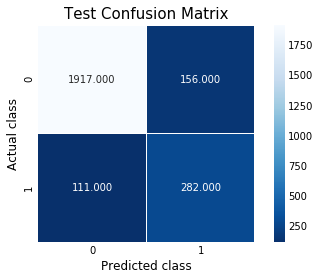

In [92]:
# RANDOM FOREST
classifier = RandomForestClassifier(criterion='entropy',  #
                                    max_depth=200,        #
                                    min_samples_split=4,  #
                                    min_samples_leaf=1, 
                                    n_estimators=80,      #
                                    random_state=1
                                   )
classifier.fit(x_train_rob_sel_2_sm, y_train_rob_sel_2_sm)
y_pred_rob_sel_2_sm = classifier.predict(x_test_rob_sel_2)

# METRICS
print(f'Train score: {round(classifier.score(x_train_rob_sel_2_sm, y_train_rob_sel_2_sm)*100, 2)}%')
print(f'Test score: {round(classifier.score(x_test_rob_sel_2, y_test_rob_sel_2)*100, 2)}%\n')

print(classification_report(y_test_rob_sel_2, y_pred_rob_sel_2_sm))

cm = confusion_matrix(y_test_rob_sel_2, y_pred_rob_sel_2_sm)

sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Test Confusion Matrix', size = 15)
plt.show()

#### Grid Search

In [93]:
rf_param_grid = {'criterion' : ['entropy'],
                 'max_depth' : [150, 200, 250],
                 'min_samples_split' : [3, 4, 5],
                 'min_samples_leaf' : [1, 2],
                 'n_estimators' : [70, 80, 90]
                 }

In [94]:
rf_grid = GridSearchCV(estimator=RandomForestClassifier(),
                       param_grid=rf_param_grid,
                       cv=5,
                       n_jobs=-1
                       #                              random_state=0
                       )

rf_grid.fit(x_train_rob_sel_2_sm, y_train_rob_sel_2_sm)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [95]:
rf_grid.best_params_

{'criterion': 'entropy',
 'max_depth': 200,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 70}

{'criterion': 'entropy',
 'max_depth': 150,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 90}

Train score: 99.95%
Test score: 88.97%

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      2073
           1       0.64      0.71      0.67       393

    accuracy                           0.89      2466
   macro avg       0.79      0.82      0.80      2466
weighted avg       0.89      0.89      0.89      2466



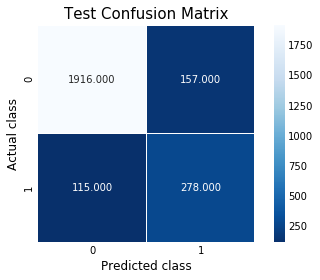

In [96]:
# RANDOM FOREST
classifier = RandomForestClassifier(criterion='entropy',  #
                                    max_depth=150,        #
                                    min_samples_split=3,  # 
                                    min_samples_leaf=1, 
                                    n_estimators=90,      #
                                    random_state=1
                                   )
classifier.fit(x_train_rob_sel_2_sm, y_train_rob_sel_2_sm)
y_pred_rob_sel_2_sm = classifier.predict(x_test_rob_sel_2)

# METRICS
print(f'Train score: {round(classifier.score(x_train_rob_sel_2_sm, y_train_rob_sel_2_sm)*100, 2)}%')
print(f'Test score: {round(classifier.score(x_test_rob_sel_2, y_test_rob_sel_2)*100, 2)}%\n')

print(classification_report(y_test_rob_sel_2, y_pred_rob_sel_2_sm))

cm = confusion_matrix(y_test_rob_sel_2, y_pred_rob_sel_2_sm)

sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Test Confusion Matrix', size = 15)
plt.show()

### SVM rbf Robust
Fail to raise metrics with tuning. Apparently best params for train set don't perform well on test set.

#### Base

C:\Users\gabri\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Train score: 89.17%
Test score: 86.74%

              precision    recall  f1-score   support

           0       0.96      0.88      0.92      2073
           1       0.56      0.80      0.66       393

    accuracy                           0.87      2466
   macro avg       0.76      0.84      0.79      2466
weighted avg       0.90      0.87      0.88      2466



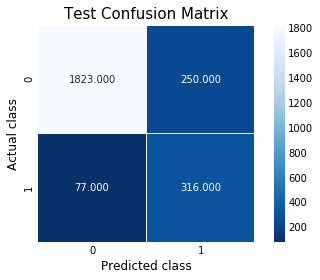

In [97]:
# SUPPORT VECTOR MACHINES
classifier = SVC(kernel='rbf', 
                 C=1.0,
                 gamma='auto_deprecated',
                 random_state=1
                )
classifier.fit(x_train_rob_sel_2_sm, y_train_rob_sel_2_sm)
y_pred_rob_sel_2_sm = classifier.predict(x_test_rob_sel_2)

# METRICS
print(f'Train score: {round(classifier.score(x_train_rob_sel_2_sm, y_train_rob_sel_2_sm)*100, 2)}%')
print(f'Test score: {round(classifier.score(x_test_rob_sel_2, y_test_rob_sel_2)*100, 2)}%\n')

print(classification_report(y_test_rob_sel_2, y_pred_rob_sel_2_sm))

cm = confusion_matrix(y_test_rob_sel_2, y_pred_rob_sel_2_sm)

sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Test Confusion Matrix', size = 15)
plt.show()

#### Random Search

In [98]:
svc_param_rand = {'C': [0.01, 0.1, 1, 10, 100], 
                 'gamma': [1, 0.1, 0.01, 0.001, 'scale', 'auto']}

In [99]:
svc_rand = RandomizedSearchCV(estimator=SVC(kernel='rbf'),
                              param_distributions=svc_param_rand,
                              cv=5,
                              n_iter=100,  # default 10
                              n_jobs=-1
                              )

svc_rand.fit(x_train_rob_sel_2_sm, y_train_rob_sel_2_sm)

C:\Users\gabri\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:266: UserWarning: The total space of parameters 30 is smaller than n_iter=100. Running 30 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=SVC(C=1.0, cache_size=200, class_weight=None,
                                 coef0=0.0, decision_function_shape='ovr',
                                 degree=3, gamma='auto_deprecated',
                                 kernel='rbf', max_iter=-1, probability=False,
                                 random_state=None, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='warn', n_iter=100, n_jobs=-1,
                   param_distributions={'C': [0.01, 0.1, 1, 10, 100],
                                        'gamma': [1, 0.1, 0.01, 0.001, 'scale',
                                                  'auto']},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=0)

In [100]:
svc_rand.best_params_

{'gamma': 0.1, 'C': 100}

{'gamma': 0.1, 'C': 100}

Train score: 95.53%
Test score: 85.48%

              precision    recall  f1-score   support

           0       0.91      0.92      0.91      2073
           1       0.55      0.49      0.52       393

    accuracy                           0.85      2466
   macro avg       0.73      0.71      0.72      2466
weighted avg       0.85      0.85      0.85      2466



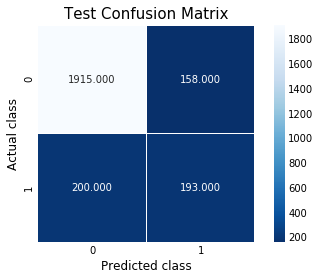

In [101]:
# SUPPORT VECTOR MACHINES
classifier = SVC(kernel='rbf', 
                 C=100,          #
                 gamma=0.1,      #
                 random_state=1
                )
classifier.fit(x_train_rob_sel_2_sm, y_train_rob_sel_2_sm)
y_pred_rob_sel_2_sm = classifier.predict(x_test_rob_sel_2)

# METRICS
print(f'Train score: {round(classifier.score(x_train_rob_sel_2_sm, y_train_rob_sel_2_sm)*100, 2)}%')
print(f'Test score: {round(classifier.score(x_test_rob_sel_2, y_test_rob_sel_2)*100, 2)}%\n')

print(classification_report(y_test_rob_sel_2, y_pred_rob_sel_2_sm))

cm = confusion_matrix(y_test_rob_sel_2, y_pred_rob_sel_2_sm)

sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Test Confusion Matrix', size = 15)
plt.show()

#### Grid Search

In [102]:
svc_param_grid = {'C': [0.01, 0.1, 1, 10, 100], 
                 'gamma': [1, 0.1, 0.01, 0.001, 'scale', 'auto']}

In [103]:
svc_grid = GridSearchCV(estimator=SVC(kernel='rbf'),
                              param_grid=svc_param_grid,
                              cv=5,
                              n_jobs=-1
                              )

svc_grid.fit(x_train_rob_sel_2_sm, y_train_rob_sel_2_sm)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'gamma': [1, 0.1, 0.01, 0.001, 'scale', 'auto']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [104]:
svc_grid.best_params_

{'C': 100, 'gamma': 0.1}

{'C': 100, 'gamma': 0.1}

Train score: 95.53%
Test score: 85.48%

              precision    recall  f1-score   support

           0       0.91      0.92      0.91      2073
           1       0.55      0.49      0.52       393

    accuracy                           0.85      2466
   macro avg       0.73      0.71      0.72      2466
weighted avg       0.85      0.85      0.85      2466



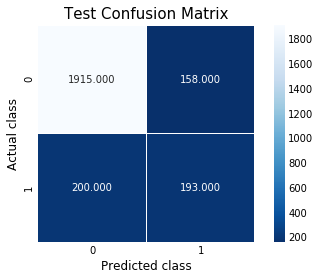

In [105]:
# SUPPORT VECTOR MACHINES
classifier = SVC(kernel='rbf', 
                 C=100,          #
                 gamma=0.1,      #
                 random_state=1
                )
classifier.fit(x_train_rob_sel_2_sm, y_train_rob_sel_2_sm)
y_pred_rob_sel_2_sm = classifier.predict(x_test_rob_sel_2)

# METRICS
print(f'Train score: {round(classifier.score(x_train_rob_sel_2_sm, y_train_rob_sel_2_sm)*100, 2)}%')
print(f'Test score: {round(classifier.score(x_test_rob_sel_2, y_test_rob_sel_2)*100, 2)}%\n')

print(classification_report(y_test_rob_sel_2, y_pred_rob_sel_2_sm))

cm = confusion_matrix(y_test_rob_sel_2, y_pred_rob_sel_2_sm)

sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Test Confusion Matrix', size = 15)
plt.show()

### MLP adam Standard
Fail to raise metrics with tuning.
Seems like no local optimum for hidden_layer_sizes and max_iter.

#### Base

Train score: 90.77%
Test score: 86.37%

              precision    recall  f1-score   support

           0       0.96      0.88      0.92      2073
           1       0.55      0.80      0.65       393

    accuracy                           0.86      2466
   macro avg       0.75      0.84      0.78      2466
weighted avg       0.89      0.86      0.87      2466



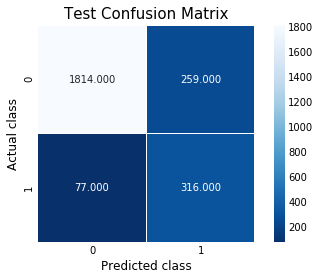

In [106]:
# MLP
classifier = MLPClassifier(hidden_layer_sizes=(100,),
                           activation='relu',
                           solver='adam', 
                           alpha=0.0001, 
                           random_state=1,
                           max_iter=1000  # MODIFIED FROM 200, FAILED TO CONVERGE
                          )
classifier.fit(x_train_std_sel_2_sm, y_train_std_sel_2_sm)
y_pred_std_sel_2_sm = classifier.predict(x_test_std_sel_2)

# METRICS
print(f'Train score: {round(classifier.score(x_train_std_sel_2_sm, y_train_std_sel_2_sm)*100, 2)}%')
print(f'Test score: {round(classifier.score(x_test_std_sel_2, y_test_std_sel_2)*100, 2)}%\n')

print(classification_report(y_test_std_sel_2, y_pred_std_sel_2_sm))

cm = confusion_matrix(y_test_std_sel_2, y_pred_std_sel_2_sm)

sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Test Confusion Matrix', size = 15)
plt.show()

#### Random Search

In [107]:
mlp_param_rand = {'hidden_layer_sizes': [(10,), (20,), (40,), (80,), (100,), (200,),
                                         (10, 10, 10), (16, 16, 16)], 
                 'activation': ['relu', 'tanh', 'logistic', 'identity'],
                 'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                 'max_iter': [1000, 2000, 4000, 8000, 10000]}

In [108]:
mlp_rand = RandomizedSearchCV(estimator=MLPClassifier(solver='adam'),
                              param_distributions=mlp_param_rand,
                              cv=5,
                              n_iter=100,  # default 10
                              n_jobs=-1
                              )

mlp_rand.fit(x_train_std_sel_2_sm, y_train_std_sel_2_sm)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                           batch_size='auto', beta_1=0.9,
                                           beta_2=0.999, early_stopping=False,
                                           epsilon=1e-08,
                                           hidden_layer_sizes=(100,),
                                           learning_rate='constant',
                                           learning_rate_init=0.001,
                                           max_iter=200, momentum=0.9,
                                           n_iter_no_change=10,
                                           nesterovs_momentum=True, power_t=0.5,
                                           rand...
                   iid='warn', n_iter=100, n_jobs=-1,
                   param_distributions={'activation': ['relu', 'tanh',
                                                       

In [109]:
mlp_rand.best_params_

{'max_iter': 4000,
 'hidden_layer_sizes': (200,),
 'alpha': 0.0001,
 'activation': 'tanh'}

{'max_iter': 8000,
 'hidden_layer_sizes': (200,),
 'alpha': 0.0001,
 'activation': 'tanh'}

Train score: 92.85%
Test score: 85.08%

              precision    recall  f1-score   support

           0       0.94      0.88      0.91      2073
           1       0.52      0.69      0.60       393

    accuracy                           0.85      2466
   macro avg       0.73      0.79      0.75      2466
weighted avg       0.87      0.85      0.86      2466



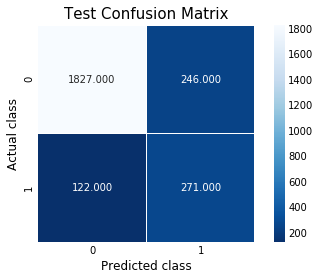

In [110]:
# MLP
classifier = MLPClassifier(hidden_layer_sizes=(200,),   #
                           activation='tanh',           #
                           solver='adam', 
                           alpha=0.0001, 
                           random_state=1,
                           max_iter=8000                #
                          )
classifier.fit(x_train_std_sel_2_sm, y_train_std_sel_2_sm)
y_pred_std_sel_2_sm = classifier.predict(x_test_std_sel_2)

# METRICS
print(f'Train score: {round(classifier.score(x_train_std_sel_2_sm, y_train_std_sel_2_sm)*100, 2)}%')
print(f'Test score: {round(classifier.score(x_test_std_sel_2, y_test_std_sel_2)*100, 2)}%\n')

print(classification_report(y_test_std_sel_2, y_pred_std_sel_2_sm))

cm = confusion_matrix(y_test_std_sel_2, y_pred_std_sel_2_sm)

sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Test Confusion Matrix', size = 15)
plt.show()

## Pick Final Model

Tuned RF fail to surpass both untuned SVM & MLP models. Recall 1 for untuned SVM and MLP is tied at 0.80. SVM has slightly better test score (+0.4%) with faster execute time (almost half the time it took MLP). So this model is selected to be deployed.

Steps taken:
* Encode categorical data*
* Use only below features
    1. Administrative_Duration
    2. BounceRates
    3. Informational_Duration
    4. Month_Mar*
    5. Month_May*
    6. Month_Nov*
    7. OperatingSystems_3*
    8. PageValues
    9. ProductRelated_Duration
    10. SpecialDay
    11. TrafficType_1*
    12. TrafficType_13*
    13. TrafficType_2*
    14. TrafficType_3*
    15. VisitorType_New_Visitor*
    16. VisitorType_Returning_Visitor*
* Scale numerical data with robust scaler
* Split train/test data to 80/20 ratio
* Oversample train data with SMOTE
* Fit train data into SVC(kernel='rbf')
* Predict

## Extra: Cross-Validation

Once we are done with training our model, we just can’t assume that it is going to work well on data that it has not seen before. In other words, we cant be sure that the model will have the desired accuracy and variance in production environment. We need some kind of assurance of the accuracy of the predictions that our model is putting out. For this, we need to validate our model. This process of deciding whether the numerical results quantifying hypothesised relationships between variables, are acceptable as descriptions of the data, is known as validation..

To evaluate the performance of any machine learning model we need to test it on some unseen data. Based on the models performance on unseen data we can say wether our model is underfit/overfit/well generalised.

[https://towardsdatascience.com/why-and-how-to-cross-validate-a-model-d6424b45261f]


As expected, developed models are still overfitted to the train data. Their performance with never-seen-before data can be measured with cross_val_score which is quite low compared to test metrics.

Train score: 99.69%
Test score: 89.13%

              precision    recall  f1-score   support

           0       0.94      0.93      0.93      2073
           1       0.65      0.71      0.67       393

    accuracy                           0.89      2466
   macro avg       0.79      0.82      0.80      2466
weighted avg       0.90      0.89      0.89      2466



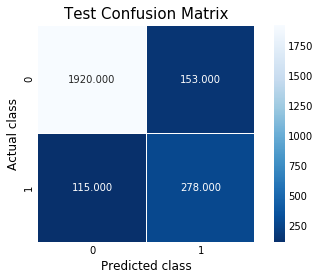

In [111]:
# RANDOM FOREST
model_rf = RandomForestClassifier(criterion='entropy',  #
                                    max_depth=200,        #
                                    min_samples_split=4,  #
                                    min_samples_leaf=1, 
                                    n_estimators=80,      #
#                                     random_state=1
                                   )
model_rf.fit(x_train_rob_sel_2_sm, y_train_rob_sel_2_sm)
y_pred_rob_sel_2_sm = model_rf.predict(x_test_rob_sel_2)

# METRICS
print(f'Train score: {round(model_rf.score(x_train_rob_sel_2_sm, y_train_rob_sel_2_sm)*100, 2)}%')
print(f'Test score: {round(model_rf.score(x_test_rob_sel_2, y_test_rob_sel_2)*100, 2)}%\n')

print(classification_report(y_test_rob_sel_2, y_pred_rob_sel_2_sm))

cm = confusion_matrix(y_test_rob_sel_2, y_pred_rob_sel_2_sm)

sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Test Confusion Matrix', size = 15)
plt.show()

In [112]:
cv_rf  = cross_val_score(estimator=model_rf,
                         X=X_rob,
                         y=y_rob,
                         # The recall is the ratio tp / (tp + fn)
                         scoring='recall',
                         n_jobs=-1,
                         # For int/None inputs, if the estimator is a classifier and y is either binary or multiclass, StratifiedKFold is used. In all other cases, KFold is used.
                         cv=5
                         )
cv_rf

array([0.5078534 , 0.52094241, 0.54450262, 0.48031496, 0.55643045])

In [113]:
print(cv_rf.mean())
print(cv_rf.std())

0.5220087672287038
0.02694702305902811


Train score: 89.17%
Test score: 86.74%

              precision    recall  f1-score   support

           0       0.96      0.88      0.92      2073
           1       0.56      0.80      0.66       393

    accuracy                           0.87      2466
   macro avg       0.76      0.84      0.79      2466
weighted avg       0.90      0.87      0.88      2466



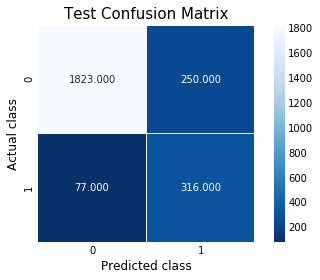

In [114]:
# SUPPORT VECTOR MACHINES
model_svm = SVC(kernel='rbf', 
                 C=1.0,
                 gamma='auto',
#                  random_state=1
                )
model_svm.fit(x_train_rob_sel_2_sm, y_train_rob_sel_2_sm)
y_pred_rob_sel_2_sm = model_svm.predict(x_test_rob_sel_2)

# METRICS
print(f'Train score: {round(model_svm.score(x_train_rob_sel_2_sm, y_train_rob_sel_2_sm)*100, 2)}%')
print(f'Test score: {round(model_svm.score(x_test_rob_sel_2, y_test_rob_sel_2)*100, 2)}%\n')

print(classification_report(y_test_rob_sel_2, y_pred_rob_sel_2_sm))

cm = confusion_matrix(y_test_rob_sel_2, y_pred_rob_sel_2_sm)

sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Test Confusion Matrix', size = 15)
plt.show()

In [132]:
model_svm.support_vectors_

array([[ 1.        , -0.18512753,  0.        , ...,  0.        ,
         1.        ,  1.        ],
       [ 1.        , -0.18512753,  0.        , ...,  1.        ,
         1.        ,  0.        ],
       [ 1.        , -0.18512753,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.        , -0.18512753,  0.        , ...,  0.        ,
         1.        ,  1.        ],
       [ 0.44938648,  0.10383695,  0.        , ...,  0.55061352,
         1.        ,  0.44938648],
       [ 1.        ,  0.4651677 ,  0.        , ...,  0.        ,
         0.68177166,  1.        ]])

In [115]:
cv_svm = cross_val_score(estimator=model_svm,
                         X=X_rob,
                         y=y_rob,
                         # The recall is the ratio tp / (tp + fn)
                         scoring='recall',
                         n_jobs=-1,
                         # For int/None inputs, if the estimator is a classifier and y is either binary or multiclass, StratifiedKFold is used. In all other cases, KFold is used.
                         cv=5
                         )
cv_svm

array([0.53664921, 0.62041885, 0.54712042, 0.42782152, 0.44356955])

In [116]:
print(cv_svm.mean())
print(cv_svm.std())

0.5151159115581756
0.07115598610066383


Train score: 91.91%
Test score: 86.66%

              precision    recall  f1-score   support

           0       0.95      0.89      0.92      2073
           1       0.56      0.75      0.64       393

    accuracy                           0.87      2466
   macro avg       0.76      0.82      0.78      2466
weighted avg       0.89      0.87      0.87      2466



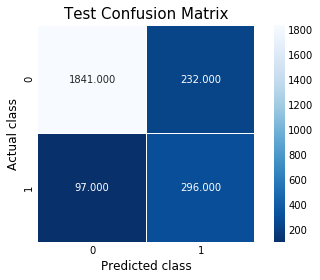

In [117]:
# MLP
model_mlp = MLPClassifier(hidden_layer_sizes=(100,),
                           activation='relu',
                           solver='adam', 
                           alpha=0.0001, 
#                            random_state=1,
                           max_iter=1000
                          )
model_mlp.fit(x_train_std_sel_2_sm, y_train_std_sel_2_sm)
y_pred_std_sel_2_sm = model_mlp.predict(x_test_std_sel_2)

# METRICS
print(f'Train score: {round(model_mlp.score(x_train_std_sel_2_sm, y_train_std_sel_2_sm)*100, 2)}%')
print(f'Test score: {round(model_mlp.score(x_test_std_sel_2, y_test_std_sel_2)*100, 2)}%\n')

print(classification_report(y_test_std_sel_2, y_pred_std_sel_2_sm))

cm = confusion_matrix(y_test_std_sel_2, y_pred_std_sel_2_sm)

sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Test Confusion Matrix', size = 15)
plt.show()

In [118]:
cv_mlp = cross_val_score(estimator=model_mlp,
                         X=X_rob,
                         y=y_rob,
                         # The recall is the ratio tp / (tp + fn)
                         scoring='recall',
                         n_jobs=-1,
                         # For int/None inputs, if the estimator is a classifier and y is either binary or multiclass, StratifiedKFold is used. In all other cases, KFold is used.
                         cv=5
                         )
cv_mlp

array([0.58638743, 0.58900524, 0.64659686, 0.54068241, 0.57742782])

In [119]:
print(cv_mlp.mean())
print(cv_mlp.std())

0.5880199530032568
0.03402330246818551


## Other

### Model Pipeline (Experimental)
Cannot include oversampling in the pipeline -- this is a know limitation of the sklearn's pipeline current design [https://stackoverflow.com/questions/29330093/how-to-add-oversampling-undersampling-procedure-in-scikits-pipeline]

In [123]:
# import the BaseEstimator
from sklearn.base import BaseEstimator

# define the class OutletTypeEncoder
# This will be our custom transformer that will create 3 new binary columns
# custom transformer must have methods fit and transform
class CategoricalEncoder(BaseEstimator):

    def __init__(self):
        pass

    def fit(self, documents, y=None):
        return self

    def transform(self, x_dataset):
#         x_dataset['Revenue'] = (x_dataset['Revenue'] == True)*1
        
        x_dataset['Month_Mar'] = (x_dataset['Month'] == 'Mar')*1
        x_dataset['Month_May'] = (x_dataset['Month'] == 'May')*1
        x_dataset['Month_Nov'] = (x_dataset['Month'] == 'Nov')*1
        
        x_dataset['OperatingSystems_3'] = (x_dataset['OperatingSystems'] == 3)*1
        
        x_dataset['TrafficType_1'] = (x_dataset['TrafficType'] == 1)*1
        x_dataset['TrafficType_2'] = (x_dataset['TrafficType'] == 2)*1
        x_dataset['TrafficType_3'] = (x_dataset['TrafficType'] == 3)*1
        x_dataset['TrafficType_13'] = (x_dataset['TrafficType'] == 13)*1
        
        x_dataset['VisitorType_New_Visitor'] = (x_dataset['VisitorType'] == 'New_Visitor')*1
        x_dataset['VisitorType_Returning_Visitor'] = (x_dataset['VisitorType'] == 'Returning_Visitor')*1
        
        return x_dataset

In [124]:
# pre-processsing step
# Drop the columns - 
# Impute the missing values in column Item_Weight by mean
# Scale the data in the column Item_MRP
from sklearn.compose import ColumnTransformer 

pre_process = ColumnTransformer(remainder='passthrough',
                                transformers=[('drop_columns', 'drop', ['Administrative',
                                                                        'Informational',
                                                                        'ProductRelated',
                                                                        'ExitRates',
                                                                        'Weekend',
                                                                        'Month',
                                                                        'OperatingSystems',
                                                                        'Browser',
                                                                        'Region',
                                                                        'TrafficType',
                                                                        'VisitorType'
                                                                       ]),
                                              ('scale_data', RobustScaler(),['Administrative_Duration', 
                                                                             'Informational_Duration', 
                                                                             'ProductRelated_Duration', 
                                                                             'BounceRates',
                                                                             'PageValues', 
                                                                             'SpecialDay'])
                                             ])

In [125]:

# Define the Pipeline
"""
Step1: get the categorical binary columns
Step2: pre processing
Step3: Train a Random Forest Model
"""
from sklearn.pipeline import Pipeline

model_pipeline = Pipeline(steps=[('get_categorical_binary_columns', CategoricalEncoder()), 
                                 ('pre_processing',pre_process),
                                 ('svm', SVC(kernel='rbf', 
                                             C=1.0, 
                                             gamma='auto_deprecated', 
                                             random_state=1))
                                 ])


In [126]:
df_p = pd.read_csv('online_shoppers_intention.csv')

df_p['Revenue'] = label_encoder.fit_transform(df_p['Revenue'])

X_p = df_p.drop(columns='Revenue')
y_p = df_p['Revenue']

x_train_p, x_test_p, y_train_p, y_test_p = train_test_split(X_p, y_p, test_size = 0.20, random_state = 88)

# sm = SMOTE(random_state = 7) 
# x_train_p_sm, y_train_p_sm = sm.fit_sample(x_train_p, y_train_p) 

In [127]:
# fit the pipeline with the training data
model_pipeline.fit(x_train_p, y_train_p)

# predict target values on the training data
y_pred_p = model_pipeline.predict(x_test_p)

C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\gabri\anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

In [128]:
print(classification_report(y_test_p, y_pred_p))

              precision    recall  f1-score   support

           0       0.91      0.96      0.94      2073
           1       0.72      0.49      0.58       393

    accuracy                           0.89      2466
   macro avg       0.81      0.73      0.76      2466
weighted avg       0.88      0.89      0.88      2466

